# Проект по поиску похожих товаров

**Цель проекта** - разработать алгоритм, который для всех товаров из validation.csv предложит несколько вариантов наиболее похожих товаров из base;
**Метрики качества в проекте:**
-  качество алгоритма по метрике accuracy@5

**Исходные данные**
base.csv - анонимизированный набор товаров. Каждый товар представлен как уникальный id (0-base, 1-base, 2-base) и вектор признаков размерностью 72.
train.csv - обучающий датасет. Каждая строчка - один товар, для которого известен уникальный id (0-query, 1-query, …) , вектор признаков И id товара из base.csv, который максимально похож на него (по мнению экспертов).
validation.csv - датасет с товарами (уникальный id и вектор признаков), для которых надо найти наиболее близкие товары из base.csv
validation_answer.csv - правильные ответы к предыдущему файлу.

План проекта

1. Настроить окружение и создать необходимые для работы функции.
2. Загрузить и изучить данные. 
2. Заполнить пропущенные значения и работа с аномалиями в столбцах.
3. Провести исследовательский анализ данных. Определить неинформативные признаки.
4. Расчитать оптимальное количество кластеров
5. Применить библиотеку FAISS. Оценить результаты на валидационной выборке по финальной метрике по метрике accuracy@5
5. Обучить разные модели, одна из которых — LightGBM, как минимум одна — не бустинг. Для каждой модели попробовать разные гиперпараметры.
6. Выводы по итогам проекта.

## Установка окружения и создание функций

### Установка окружения и импорты

In [1]:
pip install scikit-learn==1.3.0

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install phik

In [3]:
!python --version

Python 3.11.5


In [4]:
import faiss
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import requests
import os
from urllib.parse import urlencode
import zipfile
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import(
    OneHotEncoder,
    OrdinalEncoder,
    MinMaxScaler,
    RobustScaler
)
from sklearn.preprocessing import (
    StandardScaler,
    PolynomialFeatures,
    LabelEncoder,
    FunctionTransformer
)


from sklearn.tree import DecisionTreeClassifier, plot_tree, DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC, LinearSVC

from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    mean_squared_error,
    confusion_matrix,
    accuracy_score,
    recall_score,
    precision_score,
    f1_score,
    fbeta_score,
    roc_curve,
    roc_auc_score,
    RocCurveDisplay,
    make_scorer
)

import phik
from phik import phik_matrix
from phik.report import plot_correlation_matrix

from sklearn.model_selection import cross_val_score
from sklearn.metrics import RocCurveDisplay

from itertools import combinations
from scipy.spatial.distance import euclidean,cityblock

from sklearn.model_selection import KFold, StratifiedKFold

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer

from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif 


import time
from scipy.stats import pearsonr
from sklearn.inspection import permutation_importance
from sklearn.datasets import make_classification


from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import matplotlib.pyplot as plt
import seaborn as sns

In [56]:
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, jaccard_score
from scipy.spatial.distance import mahalanobis
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.preprocessing import StandardScaler

In [6]:
print(f"Faiss version: {faiss.__version__}")

Faiss version: 1.7.4


In [7]:
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)

In [8]:
import warnings
warnings.filterwarnings("ignore")

!Заменить на try exept с ссылкой на репозиторий на гите ( выложить туда уже распакованные файлы)


### Создание необходимых в проекте функций

In [9]:
def downloader(size: str='small'):
    if size not in ['small', 'large']:
        raise Exception('Unknown Argument')
    elif size == 'small':
        public_key = 'https://disk.yandex.ru/d/YQElc_cNQQLSOw'
    else:
        public_key = 'https://disk.yandex.ru/d/BBEphK0EHSJ5Jw'

    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'

    final_url = base_url + urlencode(dict(public_key=public_key))
    response = requests.get(final_url)
    download_url = response.json()['href']

    download_response = requests.get(download_url)
    with open('data.zip', 'wb') as f:
        f.write(download_response.content)

    zip_path = ('data.zip')

    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall()     

In [10]:
def check_df(df):
    """
    Проверяет pandas DataFrame на наличие пропущенных значений и дубликатов.
    
    Параметры:
    df (pandas.DataFrame): DataFrame для проверки.
    
    Выводит:
    - информацию о DataFrame,
    - количество и распределение пропущенных значений,
    - количество явных дубликатов,
    - первые пять строк DataFrame.
    """
    print("Общая инфо:")
    df.info()
    
    print("\nПроверка на наличие пропусков:")
    null_values = df.isnull().sum()
    if null_values.sum() > 0:
            print("В датафрейме есть пропущенные значения:")
            print(null_values)
    else:
        print("Пропущенные значения в датафрейме отсутствуют.")
    
    print("\nПроверка на наличие дубликатов:")
    duplicates = df.duplicated().sum()
    if duplicates > 0:
        print(f"В датафрейме найдено {duplicates} явных дубликатов.")
    else:
        print("Явные дубликаты в датафрейме отсутствуют.")
    
    display(df.head())

# Для получения документации функции использовать:
#help(check_df)

In [11]:
# Создадим функцию для визуализации диаграмм размаха.
def plot_boxplot(data, column_name):
    plt.figure(figsize=(14, 3))  # Задаем размер фигуры
    sns.boxplot(data=data, x=column_name, showmeans=True)  # Строим диаграмму расмаха с указанием среднего значения
    plt.title(f'Диаграмма размаха для признака "{column_name}"')  # Заголовок графика
    plt.xlabel(column_name)  # Подпись оси X
    plt.show() 

In [12]:
# Создадим функцию для интерпретации стат данных.
def interpret_boxplot(data, column_name):
    """
    Расчитывает и выводит стат показатели
    Параметры:
    df (df, название столбца): .
    
    Выводит:
    - Значений выходящих за доверительные интервалы,
    - 25% значений до Q1
    - 50% значений до Q1-Q3,
    - 25% значений превышают Q3
    - Медиана
    - Среднее
    """
    # Вычисляем квартили и межквартильный размах
    Q1 = data[column_name].quantile(0.25)
    Q3 = data[column_name].quantile(0.75)
    IQR = Q3 - Q1
    median = data[column_name].median()
    mean = data[column_name].mean()
    
    # Определяем границы усов (выбросы могут находиться за этими границами)
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Проверяем наличие выбросов
    outliers_exist = ((data[column_name] < lower_bound) | (data[column_name] > upper_bound)).any()
    outliers_message = "есть" if outliers_exist else "нет"
    
    # Выводим результаты
    print(f"Статистический анализ признака:")
    print(f"1. Значений выходящих за доверительные интервалы {outliers_message}.")
    print(f"2. 25% значений '{column_name}' - до {Q1}.")
    print(f"3. 50% значений '{column_name}' в диапазоне от {Q1} до {Q3}.")
    print(f"4. 25% значений '{column_name}' превышают {Q3}.")
    print(f"5. Медиана {round(median, 2)}")
    print(f"6. Среднее {round(mean, 2)}")
# Для получения документации функции использовать:
#help(interpret_boxplot)

In [13]:
# Оптимизация числовых типов данных
def optimize_memory_usage(df: pd.DataFrame, print_size: bool=True) -> pd.DataFrame:
    '''
    Function optimizes memory usage in dataframe
    df: pd.DataFrame - data table
    print_size: bool - display of optimization results
    return pd.DataFrame - amount of optimized memory
    '''
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64'] # Типы, которые будем проверять на оптимизацию
    # Размер занимаемой памяти до оптимизации (в Мб)
    before_size = df.memory_usage().sum() / 1024**2    
    for column in df.columns:
        column_type = df[column].dtypes
        if column_type in numerics:
            column_min = df[column].min()
            column_max = df[column].max()
            if str(column_type).startswith('int'):
                if column_min > np.iinfo(np.int8).min and column_max < np.iinfo(np.int8).max:
                    df[column] = df[column].astype(np.int8)
                elif column_min > np.iinfo(np.int16).min and column_max < np.iinfo(np.int16).max:
                    df[column] = df[column].astype(np.int16)
                elif column_min > np.iinfo(np.int32).min and column_max < np.iinfo(np.int32).max:
                    df[column] = df[column].astype(np.int32)
                elif column_min > np.iinfo(np.int64).min and column_max < np.iinfo(np.int64).max:
                    df[column] = df[column].astype(np.int64)  
            else:
                if column_min > np.finfo(np.float32).min and column_max < np.finfo(np.float32).max:
                    df[column] = df[column].astype(np.float32)
                else:
                    df[column] = df[column].astype(np.float64)    
    # Размер занимаемой памяти после оптимизации (в Мб)
    after_size = df.memory_usage().sum() / 1024**2
    if print_size: print('Размер использования памяти: до {:5.2f} Mb - после {:5.2f} Mb ({:.1f}%)'
                         .format(before_size, after_size, 100 * (before_size - after_size) / before_size))
    return df

## Загрузка данных

In [14]:
%%time
downloader('small')

CPU times: total: 1.16 s
Wall time: 17.9 s


In [15]:
%%time
df_base = pd.read_csv("base.csv",  decimal=',', index_col=0)
df_base.head()

CPU times: total: 5.33 s
Wall time: 7.86 s


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4207931-base,-43.946243,15.364378,17.515854,-132.31146,157.06442,-4.069252,-340.6308601716785,-57.55014,128.39822,45.090958,-126.84374,4.494522,-99.84231,44.926903,177.52173,-12.29179,38.47036,105.35765,-142.46024,-80.16326,-110.368935,1047.5173571825055,-69.59462,66.31354,84.87387,813.7700714289165,-81.03878,16.162964,-98.24488,159.53406,27.554913,-209.18428,62.05977,-529.2950529513196,114.59833,90.469894,-20.256914,-164.768,-133.31387,-41.25296,-10.251193,8.289038,-131.31271,75.7045,-16.48307795619504,40.771038,-146.09674,-143.40768,49.807987,63.43448,-30.25008,20.470263,78.07991,-128.91531,92.32768,63.88557,-141.17464,142.90259,-93.068596,-568.4215844559856,-90.01869,-129.01567,-71.92717,30.711966,-90.190475,-24.93127090365149,66.972534,106.346634,-44.270622,155.98834,-1074.4648878939415,-25.066608
2710972-base,-73.00489,4.9233418,-19.750746,-136.52908,99.90717,-70.70911,-567.4019964128371,-128.89015,109.914986,201.4722,-186.2265,29.896042,-99.770996,0.12630177,136.19049,-35.22474,-30.321323,-43.148834,-162.85175,-79.71451,-75.78487,1507.23127421948,-69.654564,43.640663,-4.779669,813.7700714289165,43.976913,11.924875,-50.228523,166.0082,-59.505333,-115.33252,72.18324,-735.6713646911912,96.3223,85.79636,-22.03033,-147.54501,-108.38295,-45.084892,-15.004004,-1.5328264,-46.456585,197.57895,-56.199875840705765,60.29871,-102.65334,-108.967964,58.512012,-9.678028,-85.4483,-68.68608,71.5902,-232.42569,91.706856,63.290657,-137.33595,-47.124687,-148.0574,-543.7870561287908,-160.6516,-133.46222,-109.04466,20.916021,-171.20139,-110.59684413773898,67.7301,8.909615,-9.470253,133.29536,-545.8970139133596,-72.91323
1371460-base,-85.56557,-0.49359798,-48.374817,-157.98502,96.80951,-81.71021,-22.29768837721059,79.76867,124.357086,105.71518,-149.80756,-54.50168,-21.037973,-24.88766,128.38864,-58.558483,34.862656,19.784412,-130.9182,-79.03223,-166.63525,1507.23127421948,-8.495993,61.205086,25.895348,813.7700714289165,-140.76886,20.87279,-123.95757,126.34781,11.713674,-125.025154,152.6859,-1018.4695451281018,-22.4446,73.89764,9.190645,-156.51881,-92.18573,-34.92676,-13.277475,16.026424,-33.853546,119.60452,-52.52534060778231,71.20475,-178.70294,-88.2785,30.501453,16.651737,-88.377014,-55.883583,70.18298,-89.233925,92.00578,76.458725,-131.14087,40.914352,-157.90054,-394.3192351955361,-87.107025,-120.772545,-58.82165,41.369606,-132.9345,-43.016838869291576,67.871925,141.77824,69.04852,111.72038,-1111.038832796031,-23.087206
3438601-base,-105.56409,15.393871,-46.223934,-158.11488,79.514114,-48.94448,-93.7130099147644,38.581398,123.39796,110.324326,-161.188,-68.51979,-0.6073303,38.733696,120.74344,-14.109269,28.868027,-29.85881,-94.30395,-79.33981,-138.98427,1507.23127421948,-131.88538,70.03136,32.736595,813.7700714289165,-62.37086,13.763219,-31.872276,139.5527,9.836465,-150.22113,80.1402,-537.183707014226,3.0916672,129.69933,-63.429424,-169.02724,-119.77007,-28.637785,-8.315162,2.7523847,-160.29382,85.08689,-18.25174973700229,90.374054,1.4799347,-121.98305,65.85266,8.355225,34.118896,-57.069756,70.4618,-127.90541,94.31428,71.25994,-135.57787,-39.982346,-159.75156,-230.1476482003609,-95.22116,-148.81409,-87.90729,-58.80687,-147.7948,-155.83023699451158,68.974754,21.39751,126.098785,139.7332,-1282.707248002355,-74.52794
422798-base,-74.63888,11.315012,-40.204174,-161.7643,50.507114,-80.77556,-640.9234672154842,65.225,122.34494,191.46585,-156.98384,-76.65021,-75.67497,12.624029,145.33752,-35.774258,11.598761,-11.460761,-201.35443,-77.779366,-120.9684,548.7368828469603,19.851685,17.943344,27.06332,813.7700714289165,-85.48378,21.236433,-95.07102,132.61092,13.526038,-160.47684,104.71937,-304.1743824159334,-15.385452,91.418655,-36.474556,-157.43959,-102.83162,-56.78271,-19.969

In [16]:
df_base.info()

<class 'pandas.core.frame.DataFrame'>
Index: 291813 entries, 4207931-base to 274130-base
Data columns (total 72 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   0       291813 non-null  object
 1   1       291813 non-null  object
 2   2       291813 non-null  object
 3   3       291813 non-null  object
 4   4       291813 non-null  object
 5   5       291813 non-null  object
 6   6       291813 non-null  object
 7   7       291813 non-null  object
 8   8       291813 non-null  object
 9   9       291813 non-null  object
 10  10      291813 non-null  object
 11  11      291813 non-null  object
 12  12      291813 non-null  object
 13  13      291813 non-null  object
 14  14      291813 non-null  object
 15  15      291813 non-null  object
 16  16      291813 non-null  object
 17  17      291813 non-null  object
 18  18      291813 non-null  object
 19  19      291813 non-null  object
 20  20      291813 non-null  object
 21  21      291813 non-nul

In [17]:
%%time
df_train = pd.read_csv("train.csv",  decimal=',', index_col=0)
df_train.head()

CPU times: total: 78.1 ms
Wall time: 248 ms


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,Target
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
109249-query,-24.021454,3.1225238,-80.947525,-112.329994,191.09018,-66.90313,-759.626064846782,-75.284454,120.55149,131.1317,-149.21106,-102.31221,21.387623,11.277594,143.2214,-22.01157,-3.6182487,-16.00548,-133.38228,-78.89356,-65.69053,407.7735748221273,-11.660624,67.00815,24.975033,813.7700714289165,40.051064,17.933155,-75.435745,149.8172,-23.413877,-178.09557,133.78647,-906.5710613479532,113.35556,83.94226,-16.592659,-146.52074,-120.23786,-27.341612,-8.845615,1.0276124,-175.64772,167.73582,-32.93155925339703,47.86096,-196.2475,-118.81005,-4.7627716,-114.87768,37.397278,-55.616966,56.627056,-108.43317,87.37256,76.51343,-136.27057,3.652915,-164.57451,-635.2842745326558,-75.647255,-116.67934,-41.234684,-24.60167,-167.76077,133.6785156767246,68.1846,26.317545,11.938202,148.54932,-778.5633808289317,-46.87775,66971-base
34137-query,-82.03358,8.115866,-8.793022,-182.9721,56.645336,-52.59761,-55.72033726883322,130.05925,129.38335,76.20288,-137.79942,33.30165,-2.8681908,-34.31877,189.06479,-19.33755,-14.20821,-71.110245,-157.74814,-78.70069,-91.741875,1054.2055997315183,-41.84563,102.12862,72.55905,813.7700714289165,-37.957787,17.598982,-159.9754,140.02528,-8.819328,-147.05518,113.81987,-529.2950529513196,70.67494,55.976795,8.817799,-134.14812,-73.679794,-57.566544,-4.3384957,-3.2706823,-144.4992,144.6502,-37.9032760689575,58.913525,-105.36284,-125.66783,19.367283,-29.087658,-35.02135,26.627962,55.718437,-110.52611,83.513374,75.92613,-135.68242,-7.429803,-180.64502,11.470170721362043,16.464691,-121.807236,-90.81445,54.448433,-120.894806,-12.292084760205569,66.608116,-27.997612,10.091335,95.809265,-1022.69153131733,-88.564705,1433819-base
136121-query,-75.71964,-0.22338629,-86.18613,-162.06406,114.320114,-53.3946,-117.26101305575943,-24.857851,124.8078,112.190155,-200.92596,-38.86518,-80.61127,14.343805,156.62129,-22.498169,-26.359468,-109.03487,-106.92659,-79.74731,-69.87683,1507.23127421948,-20.058287,34.334927,23.592144,813.7700714289165,-49.50386,22.1662,-85.74016,134.83647,-69.56985,-139.88724,67.377045,-341.7818424114949,54.161224,81.89166,36.421352,-159.99583,-131.91608,-20.495195,-13.976569,-2.3552475,-216.22865,238.83649,-56.6115358886015,43.36664,7.191841,-159.48369,-19.338009,-51.409897,36.81954,32.53688,80.68102,-232.40741,84.05369,59.08618,-139.8595,78.40944,-115.940575,2.4265720603842595,7.5948257,-126.520134,-73.14896,-5.609123,-93.02988,-80.99787090077173,63.733383,11.378683,62.932007,130.97539,-1074.4648878939415,-74.861176,290133-base
105191-query,-56.58062,5.0935926,-46.94311,-149.03912,112.43643,-76.82051,-324.9956449875206,-32.833107,119.47865,120.07479,-61.347084,-28.6706,-102.79018,-36.19432,157.18976,-33.31824,7.448413,-47.230713,-178.04608,-78.78652,-106.23544,1507.23127421948,-63.414307,38.099255,-89.79535,813.7700714289165,-107.43239,10.052701,-71.91738,147.74005,-18.750763,-143.79562,67.20731,-366.13944587412,112.1877,78.14481,-41.08541,-132.75719,-89.44503,-19.267069,-14.866466,7.7757883,-104.30211,74.622894,-59.87513611912802,76.40647,-77.79702,-92.01658,19.3373,-37.922787,37.27127,111.63957,94.91295,-179.7254,86.60148,62.698364,-122.16293,29.87394,-53.50812,-0.9388935341920116,-36.919907,-144.555,-96.79859,21.624313,-158.88037,179.5972940075577,69.89136,-33.804955,233.91461,122.868546,-1074.4648878939415,-93.775375,1270048-base
63983-query,-52.72565,9.027046,-92.82965,-113.11101,134.12497,-42.423073,-759.626064846782,8.2611685,119.49023,172.36536,-186.64139,-84.9438,-92.339966,-30.229528,167.86163,-22.635653,0.014536381,-9.796367,-213.1018,-78.59006,-98.7283,1250.4237487186726,-43.892487,86.28845,-1.5498257,813.7700714289165,-110.35698,24.055641,-96.57827,156.5823,45.12424,-123.888504,118.03511,-607.9469124164184,52.3

In [18]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9999 entries, 109249-query to 13504-query
Data columns (total 73 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       9999 non-null   object
 1   1       9999 non-null   object
 2   2       9999 non-null   object
 3   3       9999 non-null   object
 4   4       9999 non-null   object
 5   5       9999 non-null   object
 6   6       9999 non-null   object
 7   7       9999 non-null   object
 8   8       9999 non-null   object
 9   9       9999 non-null   object
 10  10      9999 non-null   object
 11  11      9999 non-null   object
 12  12      9999 non-null   object
 13  13      9999 non-null   object
 14  14      9999 non-null   object
 15  15      9999 non-null   object
 16  16      9999 non-null   object
 17  17      9999 non-null   object
 18  18      9999 non-null   object
 19  19      9999 non-null   object
 20  20      9999 non-null   object
 21  21      9999 non-null   object
 22  22      999

In [19]:
%%time
df_validation = pd.read_csv("validation.csv",  decimal=',', index_col=0)
df_validation.head()

CPU times: total: 109 ms
Wall time: 268 ms


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
196680-query,-59.38342,8.5634365,-28.203072,-134.22534,82.73661,-150.57217,-129.17896873216924,23.670555,125.66636,108.809586,-129.48387,-178.98306,-109.600174,-8.7998085,172.95998,-20.794373,-30.065893,-14.889741,-213.47429,-81.44286,-92.55872,1507.23127421948,96.50842,87.97525,55.862797,813.7700714289165,1.6479721,16.160482,-77.401474,166.08685,-7.0859447,-114.40581,116.56427,-481.5869563643652,40.185913,73.085365,-37.582203,-140.10822,-113.26041,-64.86323,-16.001427,7.2237215,-5.791832,154.65631,-34.690982576737184,52.748238,-34.976818,-160.45952,-28.526081,11.436787,107.38664,33.11757,56.67899,-43.842407,95.18327,51.950043,-123.31064,-10.645209,-52.291348,-525.6234072830723,53.718872,-129.38846,-103.48163,79.56453,-120.31357,54.21815548907523,68.50073,32.681908,84.19686,136.41296,-1074.4648878939415,-21.233612
134615-query,-103.91215,9.742726,-15.209915,-116.3731,137.6988,-85.530075,-776.123158178352,44.48153,114.67121,95.23129,-166.03618,-66.35983,-36.001366,3.2642355,73.0693,-29.384926,22.245693,62.49841,-114.18031,-80.017426,-56.034016,914.812090281119,-23.072426,64.59154,47.07409,813.7700714289165,1.7614365,24.459257,-177.63837,157.88023,-15.6488,-174.11716,37.697598,-701.6058664737998,18.38345,81.50202,22.23146,-129.41878,-117.69812,-53.36446,-4.3946347,11.10895,-109.88005,102.26328,-47.26860339246456,52.33637,31.617912,13.088348,0.38843536,-55.594444,-37.935482,-46.97078,50.4821,-132.51833,88.67881,81.240204,-130.75761,4.710941,-114.01305,-433.6167376996439,-119.45599,-129.18834,-51.19377,49.299644,-101.89454,105.56054783934276,67.80104,13.633057,108.05138,111.864456,-841.0223305643922,-76.56798
82675-query,-117.92328,-3.5045543,-64.29939,-155.18713,156.82137,-34.082264,-537.4236530416084,54.078613,121.97396,59.321335,-90.08289,4.986931,-52.51456,52.529945,140.47353,-4.8605576,-18.06383,-36.5374,-137.92374,-79.66107,-70.73312,1507.23127421948,-7.057582,26.21356,-2.779066,813.7700714289165,-69.70441,16.080505,-90.43261,137.94106,24.971474,-138.86641,92.28719,-735.6713646911912,68.33519,78.20822,14.04361,-147.51697,-113.89963,-18.748684,-8.779379,-8.737224,-177.38287,156.10245,-35.75602704435783,65.31769,-262.90784,-96.01807,55.713432,22.165249,151.10054,-24.815138,70.9211,-121.11931,91.86982,87.153366,-138.0755,-3.3096905,14.035965,-107.5966358525053,-152.85394,-118.99784,-115.176155,48.63613,-132.17967,-0.9886959908473044,68.11125,107.065216,134.61765,134.08,27.773269189902265,-32.401714
162076-query,-90.880554,4.8885417,-39.647797,-131.7501,62.36212,-105.59327,-347.13249296818475,-83.35175,133.91331,201.14609,-193.19345,-31.961876,-11.191006,-28.481222,157.13997,-39.51394,-20.431585,30.671173,-131.63226,-79.8416,-74.22269,1507.23127421948,-75.13584,34.67843,-14.997078,401.3796236365675,-29.014805,17.788988,-87.42479,160.81638,-13.624538,-137.01877,89.403885,-388.6624729599158,-0.4465866,73.49353,3.9956799,-144.55515,-125.87352,-35.733467,-9.979044,2.0923188,-114.457405,158.60924,-58.27501639931387,96.41683,-166.10669,-36.61077,95.94446,-43.66269,33.86911,30.89594,65.87759,-106.50322,94.52601,72.289566,-152.20987,29.090012,-188.34215,-327.11794260245915,43.21247,-139.8522,-112.29379,54.884007,-177.56935,-116.3749965762748,67.88766,136.89398,124.89447,117.70775,-566.3439802731209,-90.905556
23069-query,-66.94674,10.562773,-73.78183,-149.39787,2.9386597,-51.288853,-587.1893611090173,-2.7644024,126.56105,131.90062,-131.9364,-35.794685,-155.97958,-2.1101093,137.72418,-11.544052,-12.95752,2.0281754,-129.12962,-79.461266,-72.88312,1507.23127421948,-47.1126,7.8372345,-8.623394,813.7700714289165,-60.251694,11.591301,-82.7948,134.84439,4.764982,-114.47928,83.1504,-156.2498902662079,41.852833,42.16045,-58.56596,-146.39613,-90.59503,-53.295376,-12.213

In [20]:
%%time
df_validation_answer = pd.read_csv("validation_answer.csv",  decimal=',', index_col=0)
df_validation_answer.head()

CPU times: total: 15.6 ms
Wall time: 12.9 ms


,Expected
Id,
196680-query,1087368-base
134615-query,849674-base
82675-query,4183486-base
162076-query,2879258-base
23069-query,615229-base


In [21]:
df_validation_answer.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 196680-query to 43566-query
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Expected  10000 non-null  object
dtypes: object(1)
memory usage: 156.2+ KB


Данные загружены форматы соответствуют описанию.

In [22]:


# Создаем небольшой набор данных
d = 64  # размерность
nb = 1000  # размер базы
nq = 10  # размер запроса

np.random.seed(1234)  # фиксируем рандом

xb = np.random.random((nb, d)).astype('float32')
xq = np.random.random((nq, d)).astype('float32')

# Создаем индекс
index = faiss.IndexFlatL2(d)  # L2 distance

# Добавляем данные в индекс
index.add(xb)

# Ищем ближайших соседей
D, I = index.search(xq, 5)  # топ-5 ближайших соседей

print("Distances:\n", D)
print("Indices:\n", I)

Distances:
 [[6.498582  6.581214  7.2061706 7.2272434 7.371289 ]
 [5.9835205 6.1145105 6.3035088 6.335511  6.3822074]
 [6.4348927 6.5233116 6.647867  6.651206  6.7708273]
 [5.6069155 6.519708  6.761584  6.892957  6.9729924]
 [6.433794  6.4568596 6.627587  6.723336  7.0147038]
 [6.4295607 6.4654646 7.108188  7.1799994 7.2421284]
 [5.4373245 6.3745604 7.0811343 7.2515535 7.311227 ]
 [5.690303  6.7216487 6.895551  6.9043646 7.034361 ]
 [6.2258463 6.356267  6.4129667 6.4208016 6.4338536]
 [6.3555737 6.6563873 6.826214  7.0500746 7.068037 ]]
Indices:
 [[970 250 429 856 310]
 [932  51 483 550 208]
 [247 632 175 473 246]
 [214 755 856 175 647]
 [952 516 582 238 658]
 [237 526 599   5 842]
 [479 472 254 322 633]
 [704 549 582 528  98]
 [617 392 430 364 487]
 [986 294 801   0 603]]


## Предобработка данных

In [23]:
df_base=df_base.drop_duplicates()

In [24]:
df_base=df_base.astype('float32')

In [25]:
optimize_memory_usage(df_base)

Размер использования памяти: до 79.19 Mb - после 79.19 Mb (0.0%)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4207931-base,-43.946243,15.364378,17.515854,-132.311462,157.064423,-4.069252,-340.630859,-57.550140,128.398224,45.090958,-126.843742,4.494522,-99.842308,44.926903,177.521729,-12.291790,38.470360,105.357651,-142.460236,-80.163261,-110.368935,1047.517334,-69.594620,66.313538,84.873871,813.770081,-81.038780,16.162964,-98.244881,159.534058,27.554913,-209.184280,62.059769,-529.295044,114.598328,90.469894,-20.256914,-164.768005,-133.313873,-41.252960,-10.251193,8.289038,-131.312714,75.704498,-16.483078,40.771038,-146.096741,-143.407684,49.807987,63.434479,-30.250080,20.470263,78.079910,-128.915314,92.327682,63.885571,-141.174637,142.902588,-93.068596,-568.421570,-90.018692,-129.015671,-71.927170,30.711966,-90.190475,-24.931271,66.972534,106.346634,-44.270622,155.988342,-1074.464844,-25.066608
2710972-base,-73.004890,4.923342,-19.750746,-136.529083,99.907173,-70.709106,-567.401978,-128.890152,109.914986,201.472198,-186.226501,29.896042,-99.770996,0.126302,136.190491,-35.224739,-30.321323,-43.148834,-162.851746,-79.714508,-75.784866,1507.231323,-69.654564,43.640663,-4.779669,813.770081,43.976913,11.924875,-50.228523,166.008194,-59.505333,-115.332520,72.183243,-735.671387,96.322304,85.796356,-22.030331,-147.545013,-108.382950,-45.084892,-15.004004,-1.532826,-46.456585,197.578949,-56.199875,60.298710,-102.653343,-108.967964,58.512012,-9.678028,-85.448303,-68.686081,71.590202,-232.425690,91.706856,63.290657,-137.335953,-47.124687,-148.057404,-543.787048,-160.651596,-133.462219,-109.044662,20.916021,-171.201385,-110.596848,67.730103,8.909615,-9.470253,133.295364,-545.897034,-72.913231
1371460-base,-85.565567,-0.493598,-48.374817,-157.985016,96.809509,-81.710213,-22.297688,79.768669,124.357086,105.715179,-149.807556,-54.501678,-21.037973,-24.887659,128.388641,-58.558483,34.862656,19.784412,-130.918198,-79.032227,-166.635254,1507.231323,-8.495993,61.205086,25.895348,813.770081,-140.768860,20.872789,-123.957573,126.347809,11.713674,-125.025154,152.685898,-1018.469543,-22.444599,73.897636,9.190645,-156.518814,-92.185730,-34.926762,-13.277475,16.026424,-33.853546,119.604523,-52.525341,71.204750,-178.702942,-88.278503,30.501453,16.651737,-88.377014,-55.883583,70.182983,-89.233925,92.005783,76.458725,-131.140869,40.914352,-157.900543,-394.319244,-87.107025,-120.772545,-58.821651,41.369606,-132.934494,-43.016838,67.871925,141.778244,69.048523,111.720383,-1111.038818,-23.087206
3438601-base,-105.564087,15.393871,-46.223934,-158.114883,79.514114,-48.944481,-93.713013,38.581398,123.397957,110.324326,-161.188004,-68.519791,-0.607330,38.733696,120.743439,-14.109269,28.868027,-29.858810,-94.303947,-79.339813,-138.984268,1507.231323,-131.885376,70.031357,32.736595,813.770081,-62.370861,13.763219,-31.872276,139.552704,9.836465,-150.221130,80.140198,-537.183716,3.091667,129.699326,-63.429424,-169.027237,-119.770073,-28.637785,-8.315162,2.752385,-160.293823,85.086891,-18.251749,90.374054,1.479935,-121.983047,65.852661,8.355225,34.118896,-57.069756,70.461800,-127.905411,94.314278,71.259941,-135.577866,-39.982346,-159.751556,-230.147644,-95.221161,-148.814087,-87.907288,-58.806870,-147.794800,-155.830231,68.974754,21.397511,126.098785,139.733200,-1282.707275,-74.527939
422798-base,-74.638878,11.315012,-40.204174,-161.764297,50.507114,-80.775558,-640.923462,65.224998,122.344940,191.465851,-156.983841,-76.650208,-75.674973,12.624029,145.337524,-35.774258,11.598761,-11.460761,-201.354431,-77.779366,-120.968399,548.736877,19.851685,17.943344,27.063320,813.770081,-85.483780,21.236433,-95.071022,132.610916,13.526038,-160.476837,104.719368,-304.174377,-15.385452,91.418655,-36.474556,-157.439590,-102.831619,-56.782711,-19.969252,-0.598189,-222.228790,33.441666,-56.092110,71.276031,-8.71350

In [26]:
check_df(df_base)

Общая инфо:
<class 'pandas.core.frame.DataFrame'>
Index: 280535 entries, 4207931-base to 274130-base
Data columns (total 72 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       280535 non-null  float32
 1   1       280535 non-null  float32
 2   2       280535 non-null  float32
 3   3       280535 non-null  float32
 4   4       280535 non-null  float32
 5   5       280535 non-null  float32
 6   6       280535 non-null  float32
 7   7       280535 non-null  float32
 8   8       280535 non-null  float32
 9   9       280535 non-null  float32
 10  10      280535 non-null  float32
 11  11      280535 non-null  float32
 12  12      280535 non-null  float32
 13  13      280535 non-null  float32
 14  14      280535 non-null  float32
 15  15      280535 non-null  float32
 16  16      280535 non-null  float32
 17  17      280535 non-null  float32
 18  18      280535 non-null  float32
 19  19      280535 non-null  float32
 20  20      280535 non-null  

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4207931-base,-43.946243,15.364378,17.515854,-132.311462,157.064423,-4.069252,-340.630859,-57.550140,128.398224,45.090958,-126.843742,4.494522,-99.842308,44.926903,177.521729,-12.291790,38.470360,105.357651,-142.460236,-80.163261,-110.368935,1047.517334,-69.594620,66.313538,84.873871,813.770081,-81.038780,16.162964,-98.244881,159.534058,27.554913,-209.184280,62.059769,-529.295044,114.598328,90.469894,-20.256914,-164.768005,-133.313873,-41.252960,-10.251193,8.289038,-131.312714,75.704498,-16.483078,40.771038,-146.096741,-143.407684,49.807987,63.434479,-30.250080,20.470263,78.079910,-128.915314,92.327682,63.885571,-141.174637,142.902588,-93.068596,-568.421570,-90.018692,-129.015671,-71.927170,30.711966,-90.190475,-24.931271,66.972534,106.346634,-44.270622,155.988342,-1074.464844,-25.066608
2710972-base,-73.004890,4.923342,-19.750746,-136.529083,99.907173,-70.709106,-567.401978,-128.890152,109.914986,201.472198,-186.226501,29.896042,-99.770996,0.126302,136.190491,-35.224739,-30.321323,-43.148834,-162.851746,-79.714508,-75.784866,1507.231323,-69.654564,43.640663,-4.779669,813.770081,43.976913,11.924875,-50.228523,166.008194,-59.505333,-115.332520,72.183243,-735.671387,96.322304,85.796356,-22.030331,-147.545013,-108.382950,-45.084892,-15.004004,-1.532826,-46.456585,197.578949,-56.199875,60.298710,-102.653343,-108.967964,58.512012,-9.678028,-85.448303,-68.686081,71.590202,-232.425690,91.706856,63.290657,-137.335953,-47.124687,-148.057404,-543.787048,-160.651596,-133.462219,-109.044662,20.916021,-171.201385,-110.596848,67.730103,8.909615,-9.470253,133.295364,-545.897034,-72.913231
1371460-base,-85.565567,-0.493598,-48.374817,-157.985016,96.809509,-81.710213,-22.297688,79.768669,124.357086,105.715179,-149.807556,-54.501678,-21.037973,-24.887659,128.388641,-58.558483,34.862656,19.784412,-130.918198,-79.032227,-166.635254,1507.231323,-8.495993,61.205086,25.895348,813.770081,-140.768860,20.872789,-123.957573,126.347809,11.713674,-125.025154,152.685898,-1018.469543,-22.444599,73.897636,9.190645,-156.518814,-92.185730,-34.926762,-13.277475,16.026424,-33.853546,119.604523,-52.525341,71.204750,-178.702942,-88.278503,30.501453,16.651737,-88.377014,-55.883583,70.182983,-89.233925,92.005783,76.458725,-131.140869,40.914352,-157.900543,-394.319244,-87.107025,-120.772545,-58.821651,41.369606,-132.934494,-43.016838,67.871925,141.778244,69.048523,111.720383,-1111.038818,-23.087206
3438601-base,-105.564087,15.393871,-46.223934,-158.114883,79.514114,-48.944481,-93.713013,38.581398,123.397957,110.324326,-161.188004,-68.519791,-0.607330,38.733696,120.743439,-14.109269,28.868027,-29.858810,-94.303947,-79.339813,-138.984268,1507.231323,-131.885376,70.031357,32.736595,813.770081,-62.370861,13.763219,-31.872276,139.552704,9.836465,-150.221130,80.140198,-537.183716,3.091667,129.699326,-63.429424,-169.027237,-119.770073,-28.637785,-8.315162,2.752385,-160.293823,85.086891,-18.251749,90.374054,1.479935,-121.983047,65.852661,8.355225,34.118896,-57.069756,70.461800,-127.905411,94.314278,71.259941,-135.577866,-39.982346,-159.751556,-230.147644,-95.221161,-148.814087,-87.907288,-58.806870,-147.794800,-155.830231,68.974754,21.397511,126.098785,139.733200,-1282.707275,-74.527939
422798-base,-74.638878,11.315012,-40.204174,-161.764297,50.507114,-80.775558,-640.923462,65.224998,122.344940,191.465851,-156.983841,-76.650208,-75.674973,12.624029,145.337524,-35.774258,11.598761,-11.460761,-201.354431,-77.779366,-120.968399,548.736877,19.851685,17.943344,27.063320,813.770081,-85.483780,21.236433,-95.071022,132.610916,13.526038,-160.476837,104.719368,-304.174377,-15.385452,91.418655,-36.474556,-157.439590,-102.831619,-56.782711,-19.969252,-0.598189,-222.228790,33.441666,-56.092110,71.276031,-8.71350

In [27]:
df_train=df_train.drop_duplicates()

In [28]:
optimize_memory_usage(df_train)

Размер использования памяти: до  5.51 Mb - после  5.51 Mb (0.0%)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,Target
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
109249-query,-24.021454,3.1225238,-80.947525,-112.329994,191.09018,-66.90313,-759.626064846782,-75.284454,120.55149,131.1317,-149.21106,-102.31221,21.387623,11.277594,143.2214,-22.01157,-3.6182487,-16.00548,-133.38228,-78.89356,-65.69053,407.7735748221273,-11.660624,67.00815,24.975033,813.7700714289165,40.051064,17.933155,-75.435745,149.8172,-23.413877,-178.09557,133.78647,-906.5710613479532,113.35556,83.94226,-16.592659,-146.52074,-120.23786,-27.341612,-8.845615,1.0276124,-175.64772,167.73582,-32.93155925339703,47.86096,-196.2475,-118.81005,-4.7627716,-114.87768,37.397278,-55.616966,56.627056,-108.43317,87.37256,76.51343,-136.27057,3.652915,-164.57451,-635.2842745326558,-75.647255,-116.67934,-41.234684,-24.60167,-167.76077,133.6785156767246,68.1846,26.317545,11.938202,148.54932,-778.5633808289317,-46.87775,66971-base
34137-query,-82.03358,8.115866,-8.793022,-182.9721,56.645336,-52.59761,-55.72033726883322,130.05925,129.38335,76.20288,-137.79942,33.30165,-2.8681908,-34.31877,189.06479,-19.33755,-14.20821,-71.110245,-157.74814,-78.70069,-91.741875,1054.2055997315183,-41.84563,102.12862,72.55905,813.7700714289165,-37.957787,17.598982,-159.9754,140.02528,-8.819328,-147.05518,113.81987,-529.2950529513196,70.67494,55.976795,8.817799,-134.14812,-73.679794,-57.566544,-4.3384957,-3.2706823,-144.4992,144.6502,-37.9032760689575,58.913525,-105.36284,-125.66783,19.367283,-29.087658,-35.02135,26.627962,55.718437,-110.52611,83.513374,75.92613,-135.68242,-7.429803,-180.64502,11.470170721362043,16.464691,-121.807236,-90.81445,54.448433,-120.894806,-12.292084760205569,66.608116,-27.997612,10.091335,95.809265,-1022.69153131733,-88.564705,1433819-base
136121-query,-75.71964,-0.22338629,-86.18613,-162.06406,114.320114,-53.3946,-117.26101305575943,-24.857851,124.8078,112.190155,-200.92596,-38.86518,-80.61127,14.343805,156.62129,-22.498169,-26.359468,-109.03487,-106.92659,-79.74731,-69.87683,1507.23127421948,-20.058287,34.334927,23.592144,813.7700714289165,-49.50386,22.1662,-85.74016,134.83647,-69.56985,-139.88724,67.377045,-341.7818424114949,54.161224,81.89166,36.421352,-159.99583,-131.91608,-20.495195,-13.976569,-2.3552475,-216.22865,238.83649,-56.6115358886015,43.36664,7.191841,-159.48369,-19.338009,-51.409897,36.81954,32.53688,80.68102,-232.40741,84.05369,59.08618,-139.8595,78.40944,-115.940575,2.4265720603842595,7.5948257,-126.520134,-73.14896,-5.609123,-93.02988,-80.99787090077173,63.733383,11.378683,62.932007,130.97539,-1074.4648878939415,-74.861176,290133-base
105191-query,-56.58062,5.0935926,-46.94311,-149.03912,112.43643,-76.82051,-324.9956449875206,-32.833107,119.47865,120.07479,-61.347084,-28.6706,-102.79018,-36.19432,157.18976,-33.31824,7.448413,-47.230713,-178.04608,-78.78652,-106.23544,1507.23127421948,-63.414307,38.099255,-89.79535,813.7700714289165,-107.43239,10.052701,-71.91738,147.74005,-18.750763,-143.79562,67.20731,-366.13944587412,112.1877,78.14481,-41.08541,-132.75719,-89.44503,-19.267069,-14.866466,7.7757883,-104.30211,74.622894,-59.87513611912802,76.40647,-77.79702,-92.01658,19.3373,-37.922787,37.27127,111.63957,94.91295,-179.7254,86.60148,62.698364,-122.16293,29.87394,-53.50812,-0.9388935341920116,-36.919907,-144.555,-96.79859,21.624313,-158.88037,179.5972940075577,69.89136,-33.804955,233.91461,122.868546,-1074.4648878939415,-93.775375,1270048-base
63983-query,-52.72565,9.027046,-92.82965,-113.11101,134.12497,-42.423073,-759.626064846782,8.2611685,119.49023,172.36536,-186.64139,-84.9438,-92.339966,-30.229528,167.86163,-22.635653,0.014536381,-9.796367,-213.1018,-78.59006,-98.7283,1250.4237487186726,-43.892487,86.28845,-1.5498257,813.7700714289165,-110.35698,24.055641,-96.57827,156.5823,45.12424,-123.888504,118.03511,-607.9469124164184,52.3

Переведем значения признаков train в корректный формат

In [29]:
# Сохраняем столбец target
target = df_train['Target']

# Преобразуем остальные столбцы в float32
df_train = df_train.drop(columns=['Target']).astype('float32')

# Объединяем обратно с target
df_train['target'] = target

# Проверим результат
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9756 entries, 109249-query to 13504-query
Data columns (total 73 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       9756 non-null   float32
 1   1       9756 non-null   float32
 2   2       9756 non-null   float32
 3   3       9756 non-null   float32
 4   4       9756 non-null   float32
 5   5       9756 non-null   float32
 6   6       9756 non-null   float32
 7   7       9756 non-null   float32
 8   8       9756 non-null   float32
 9   9       9756 non-null   float32
 10  10      9756 non-null   float32
 11  11      9756 non-null   float32
 12  12      9756 non-null   float32
 13  13      9756 non-null   float32
 14  14      9756 non-null   float32
 15  15      9756 non-null   float32
 16  16      9756 non-null   float32
 17  17      9756 non-null   float32
 18  18      9756 non-null   float32
 19  19      9756 non-null   float32
 20  20      9756 non-null   float32
 21  21      9756 non-null   

In [30]:
check_df(df_train)

Общая инфо:
<class 'pandas.core.frame.DataFrame'>
Index: 9756 entries, 109249-query to 13504-query
Data columns (total 73 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       9756 non-null   float32
 1   1       9756 non-null   float32
 2   2       9756 non-null   float32
 3   3       9756 non-null   float32
 4   4       9756 non-null   float32
 5   5       9756 non-null   float32
 6   6       9756 non-null   float32
 7   7       9756 non-null   float32
 8   8       9756 non-null   float32
 9   9       9756 non-null   float32
 10  10      9756 non-null   float32
 11  11      9756 non-null   float32
 12  12      9756 non-null   float32
 13  13      9756 non-null   float32
 14  14      9756 non-null   float32
 15  15      9756 non-null   float32
 16  16      9756 non-null   float32
 17  17      9756 non-null   float32
 18  18      9756 non-null   float32
 19  19      9756 non-null   float32
 20  20      9756 non-null   float32
 21  21      9756

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,target
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
109249-query,-24.021454,3.122524,-80.947525,-112.329994,191.090179,-66.903130,-759.626038,-75.284454,120.551491,131.131699,-149.211060,-102.312210,21.387623,11.277594,143.221405,-22.011570,-3.618249,-16.005480,-133.382278,-78.893562,-65.690529,407.773560,-11.660624,67.008148,24.975033,813.770081,40.051064,17.933155,-75.435745,149.817200,-23.413877,-178.095566,133.786469,-906.571045,113.355560,83.942261,-16.592659,-146.520737,-120.237862,-27.341612,-8.845615,1.027612,-175.647720,167.735825,-32.931561,47.860958,-196.247498,-118.810051,-4.762772,-114.877678,37.397278,-55.616966,56.627056,-108.433167,87.372559,76.513428,-136.270569,3.652915,-164.574509,-635.284302,-75.647255,-116.679337,-41.234684,-24.601669,-167.760773,133.678513,68.184601,26.317545,11.938202,148.549316,-778.563354,-46.877750,66971-base
34137-query,-82.033577,8.115866,-8.793022,-182.972107,56.645336,-52.597610,-55.720337,130.059250,129.383347,76.202881,-137.799423,33.301651,-2.868191,-34.318771,189.064789,-19.337549,-14.208210,-71.110245,-157.748138,-78.700691,-91.741875,1054.205566,-41.845631,102.128616,72.559052,813.770081,-37.957787,17.598982,-159.975403,140.025284,-8.819328,-147.055176,113.819870,-529.295044,70.674942,55.976795,8.817799,-134.148117,-73.679794,-57.566544,-4.338496,-3.270682,-144.499207,144.650208,-37.903275,58.913525,-105.362839,-125.667831,19.367283,-29.087658,-35.021351,26.627962,55.718437,-110.526108,83.513374,75.926132,-135.682419,-7.429803,-180.645020,11.470171,16.464691,-121.807236,-90.814453,54.448433,-120.894806,-12.292085,66.608116,-27.997612,10.091335,95.809265,-1022.691528,-88.564705,1433819-base
136121-query,-75.719643,-0.223386,-86.186127,-162.064056,114.320114,-53.394600,-117.261017,-24.857851,124.807800,112.190155,-200.925964,-38.865181,-80.611267,14.343805,156.621292,-22.498169,-26.359468,-109.034866,-106.926590,-79.747307,-69.876831,1507.231323,-20.058287,34.334927,23.592144,813.770081,-49.503860,22.166201,-85.740158,134.836472,-69.569847,-139.887238,67.377045,-341.781830,54.161224,81.891663,36.421352,-159.995834,-131.916077,-20.495195,-13.976569,-2.355247,-216.228653,238.836487,-56.611534,43.366638,7.191841,-159.483688,-19.338009,-51.409897,36.819538,32.536880,80.681023,-232.407410,84.053688,59.086182,-139.859497,78.409439,-115.940575,2.426572,7.594826,-126.520134,-73.148956,-5.609123,-93.029877,-80.997871,63.733383,11.378683,62.932007,130.975388,-1074.464844,-74.861176,290133-base
105191-query,-56.580620,5.093593,-46.943111,-149.039124,112.436432,-76.820511,-324.995636,-32.833107,119.478653,120.074791,-61.347084,-28.670601,-102.790176,-36.194321,157.189758,-33.318241,7.448413,-47.230713,-178.046082,-78.786522,-106.235443,1507.231323,-63.414307,38.099255,-89.795349,813.770081,-107.432388,10.052701,-71.917381,147.740051,-18.750763,-143.795624,67.207314,-366.139435,112.187698,78.144814,-41.085411,-132.757187,-89.445030,-19.267069,-14.866466,7.775788,-104.302109,74.622894,-59.875137,76.406471,-77.797020,-92.016579,19.337299,-37.922787,37.271271,111.639572,94.912949,-179.725403,86.601479,62.698364,-122.162933,29.873940,-53.508121,-0.938894,-36.919907,-144.554993,-96.798592,21.624313,-158.880371,179.597290,69.891357,-33.804955,233.914612,122.868546,-1074.464844,-93.775375,1270048-base
63983-query,-52.725651,9.027046,-92.829651,-113.111008,134.124969,-42.423073,-759.626038,8.261168,119.490227,172.365356,-186.641388,-84.943802,-92.339966,-30.229528,167.861633,-22.635653,0.014536,-9.796367,-213.101807,-78.590057,-98.728302,1250.423706,-43.892487,86.288452,-1.549826,813.770081,-110.356979,24.055641,-96.578270,156.582306,45.124241,-123.888504,118.035110,-607.946899,52.311409,76.747803,-14.161914,-143.538513,-124.886215,-64.783333,-17.706848,15.446568,

In [31]:
check_df(df_validation)

Общая инфо:
<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 196680-query to 43566-query
Data columns (total 72 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       10000 non-null  object
 1   1       10000 non-null  object
 2   2       10000 non-null  object
 3   3       10000 non-null  object
 4   4       10000 non-null  object
 5   5       10000 non-null  object
 6   6       10000 non-null  object
 7   7       10000 non-null  object
 8   8       10000 non-null  object
 9   9       10000 non-null  object
 10  10      10000 non-null  object
 11  11      10000 non-null  object
 12  12      10000 non-null  object
 13  13      10000 non-null  object
 14  14      10000 non-null  object
 15  15      10000 non-null  object
 16  16      10000 non-null  object
 17  17      10000 non-null  object
 18  18      10000 non-null  object
 19  19      10000 non-null  object
 20  20      10000 non-null  object
 21  21      10000 non-null  object
 22

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
196680-query,-59.38342,8.5634365,-28.203072,-134.22534,82.73661,-150.57217,-129.17896873216924,23.670555,125.66636,108.809586,-129.48387,-178.98306,-109.600174,-8.7998085,172.95998,-20.794373,-30.065893,-14.889741,-213.47429,-81.44286,-92.55872,1507.23127421948,96.50842,87.97525,55.862797,813.7700714289165,1.6479721,16.160482,-77.401474,166.08685,-7.0859447,-114.40581,116.56427,-481.5869563643652,40.185913,73.085365,-37.582203,-140.10822,-113.26041,-64.86323,-16.001427,7.2237215,-5.791832,154.65631,-34.690982576737184,52.748238,-34.976818,-160.45952,-28.526081,11.436787,107.38664,33.11757,56.67899,-43.842407,95.18327,51.950043,-123.31064,-10.645209,-52.291348,-525.6234072830723,53.718872,-129.38846,-103.48163,79.56453,-120.31357,54.21815548907523,68.50073,32.681908,84.19686,136.41296,-1074.4648878939415,-21.233612
134615-query,-103.91215,9.742726,-15.209915,-116.3731,137.6988,-85.530075,-776.123158178352,44.48153,114.67121,95.23129,-166.03618,-66.35983,-36.001366,3.2642355,73.0693,-29.384926,22.245693,62.49841,-114.18031,-80.017426,-56.034016,914.812090281119,-23.072426,64.59154,47.07409,813.7700714289165,1.7614365,24.459257,-177.63837,157.88023,-15.6488,-174.11716,37.697598,-701.6058664737998,18.38345,81.50202,22.23146,-129.41878,-117.69812,-53.36446,-4.3946347,11.10895,-109.88005,102.26328,-47.26860339246456,52.33637,31.617912,13.088348,0.38843536,-55.594444,-37.935482,-46.97078,50.4821,-132.51833,88.67881,81.240204,-130.75761,4.710941,-114.01305,-433.6167376996439,-119.45599,-129.18834,-51.19377,49.299644,-101.89454,105.56054783934276,67.80104,13.633057,108.05138,111.864456,-841.0223305643922,-76.56798
82675-query,-117.92328,-3.5045543,-64.29939,-155.18713,156.82137,-34.082264,-537.4236530416084,54.078613,121.97396,59.321335,-90.08289,4.986931,-52.51456,52.529945,140.47353,-4.8605576,-18.06383,-36.5374,-137.92374,-79.66107,-70.73312,1507.23127421948,-7.057582,26.21356,-2.779066,813.7700714289165,-69.70441,16.080505,-90.43261,137.94106,24.971474,-138.86641,92.28719,-735.6713646911912,68.33519,78.20822,14.04361,-147.51697,-113.89963,-18.748684,-8.779379,-8.737224,-177.38287,156.10245,-35.75602704435783,65.31769,-262.90784,-96.01807,55.713432,22.165249,151.10054,-24.815138,70.9211,-121.11931,91.86982,87.153366,-138.0755,-3.3096905,14.035965,-107.5966358525053,-152.85394,-118.99784,-115.176155,48.63613,-132.17967,-0.9886959908473044,68.11125,107.065216,134.61765,134.08,27.773269189902265,-32.401714
162076-query,-90.880554,4.8885417,-39.647797,-131.7501,62.36212,-105.59327,-347.13249296818475,-83.35175,133.91331,201.14609,-193.19345,-31.961876,-11.191006,-28.481222,157.13997,-39.51394,-20.431585,30.671173,-131.63226,-79.8416,-74.22269,1507.23127421948,-75.13584,34.67843,-14.997078,401.3796236365675,-29.014805,17.788988,-87.42479,160.81638,-13.624538,-137.01877,89.403885,-388.6624729599158,-0.4465866,73.49353,3.9956799,-144.55515,-125.87352,-35.733467,-9.979044,2.0923188,-114.457405,158.60924,-58.27501639931387,96.41683,-166.10669,-36.61077,95.94446,-43.66269,33.86911,30.89594,65.87759,-106.50322,94.52601,72.289566,-152.20987,29.090012,-188.34215,-327.11794260245915,43.21247,-139.8522,-112.29379,54.884007,-177.56935,-116.3749965762748,67.88766,136.89398,124.89447,117.70775,-566.3439802731209,-90.905556
23069-query,-66.94674,10.562773,-73.78183,-149.39787,2.9386597,-51.288853,-587.1893611090173,-2.7644024,126.56105,131.90062,-131.9364,-35.794685,-155.97958,-2.1101093,137.72418,-11.544052,-12.95752,2.0281754,-129.12962,-79.461266,-72.88312,1507.23127421948,-47.1126,7.8372345,-8.623394,813.7700714289165,-60.251694,11.591301,-82.7948,134.84439,4.764982,-114.47928,83.1504,-156.2498902662079,41.852833,42.16045,-58.56596,-146.39613,-90.59503,-53.295376,-12.213

In [32]:
df_validation=df_validation.drop_duplicates()

In [33]:
df_validation=df_validation.astype('float32')

In [34]:
check_df(df_validation)

Общая инфо:
<class 'pandas.core.frame.DataFrame'>
Index: 9735 entries, 196680-query to 43566-query
Data columns (total 72 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       9735 non-null   float32
 1   1       9735 non-null   float32
 2   2       9735 non-null   float32
 3   3       9735 non-null   float32
 4   4       9735 non-null   float32
 5   5       9735 non-null   float32
 6   6       9735 non-null   float32
 7   7       9735 non-null   float32
 8   8       9735 non-null   float32
 9   9       9735 non-null   float32
 10  10      9735 non-null   float32
 11  11      9735 non-null   float32
 12  12      9735 non-null   float32
 13  13      9735 non-null   float32
 14  14      9735 non-null   float32
 15  15      9735 non-null   float32
 16  16      9735 non-null   float32
 17  17      9735 non-null   float32
 18  18      9735 non-null   float32
 19  19      9735 non-null   float32
 20  20      9735 non-null   float32
 21  21      9735

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
196680-query,-59.383419,8.563437,-28.203072,-134.225342,82.736610,-150.572174,-129.178970,23.670555,125.666359,108.809586,-129.483871,-178.983063,-109.600174,-8.799809,172.959976,-20.794373,-30.065893,-14.889741,-213.474289,-81.442863,-92.558723,1507.231323,96.508423,87.975250,55.862797,813.770081,1.647972,16.160482,-77.401474,166.086853,-7.085945,-114.405807,116.564270,-481.586945,40.185913,73.085365,-37.582203,-140.108215,-113.260406,-64.863228,-16.001427,7.223722,-5.791832,154.656311,-34.690983,52.748238,-34.976818,-160.459518,-28.526081,11.436787,107.386642,33.117569,56.678989,-43.842407,95.183273,51.950043,-123.310638,-10.645209,-52.291348,-525.623413,53.718872,-129.388458,-103.481628,79.564529,-120.313568,54.218155,68.500732,32.681908,84.196861,136.412964,-1074.464844,-21.233612
134615-query,-103.912148,9.742726,-15.209915,-116.373100,137.698807,-85.530075,-776.123169,44.481529,114.671211,95.231293,-166.036179,-66.359833,-36.001366,3.264235,73.069298,-29.384926,22.245693,62.498409,-114.180313,-80.017426,-56.034016,914.812073,-23.072426,64.591537,47.074089,813.770081,1.761436,24.459257,-177.638367,157.880234,-15.648800,-174.117157,37.697598,-701.605896,18.383450,81.502022,22.231461,-129.418777,-117.698120,-53.364460,-4.394635,11.108950,-109.880051,102.263283,-47.268604,52.336369,31.617912,13.088348,0.388435,-55.594444,-37.935482,-46.970779,50.482101,-132.518326,88.678810,81.240204,-130.757614,4.710941,-114.013046,-433.616730,-119.455994,-129.188339,-51.193771,49.299644,-101.894539,105.560547,67.801041,13.633057,108.051376,111.864456,-841.022339,-76.567978
82675-query,-117.923279,-3.504554,-64.299393,-155.187134,156.821365,-34.082264,-537.423645,54.078613,121.973961,59.321335,-90.082893,4.986931,-52.514561,52.529945,140.473526,-4.860558,-18.063829,-36.537399,-137.923737,-79.661072,-70.733124,1507.231323,-7.057582,26.213560,-2.779066,813.770081,-69.704407,16.080505,-90.432610,137.941055,24.971474,-138.866409,92.287193,-735.671387,68.335190,78.208221,14.043610,-147.516968,-113.899628,-18.748684,-8.779379,-8.737224,-177.382874,156.102448,-35.756027,65.317688,-262.907837,-96.018066,55.713432,22.165249,151.100540,-24.815138,70.921097,-121.119308,91.869820,87.153366,-138.075500,-3.309690,14.035965,-107.596634,-152.853943,-118.997841,-115.176155,48.636131,-132.179672,-0.988696,68.111252,107.065216,134.617645,134.080002,27.773270,-32.401714
162076-query,-90.880554,4.888542,-39.647797,-131.750107,62.362122,-105.593269,-347.132507,-83.351753,133.913315,201.146088,-193.193451,-31.961876,-11.191006,-28.481222,157.139969,-39.513939,-20.431585,30.671173,-131.632263,-79.841599,-74.222687,1507.231323,-75.135841,34.678429,-14.997078,401.379639,-29.014805,17.788988,-87.424789,160.816376,-13.624538,-137.018768,89.403885,-388.662476,-0.446587,73.493530,3.995680,-144.555145,-125.873520,-35.733467,-9.979044,2.092319,-114.457405,158.609238,-58.275017,96.416832,-166.106689,-36.610771,95.944458,-43.662689,33.869110,30.895941,65.877586,-106.503220,94.526009,72.289566,-152.209869,29.090012,-188.342148,-327.117950,43.212471,-139.852203,-112.293793,54.884007,-177.569351,-116.375000,67.887657,136.893982,124.894470,117.707748,-566.343994,-90.905556
23069-query,-66.946739,10.562773,-73.781830,-149.397873,2.938660,-51.288853,-587.189331,-2.764402,126.561050,131.900620,-131.936401,-35.794685,-155.979584,-2.110109,137.724182,-11.544052,-12.957520,2.028175,-129.129623,-79.461266,-72.883118,1507.231323,-47.112598,7.837234,-8.623394,813.770081,-60.251694,11.591301,-82.794800,134.844391,4.764982,-114.479279,83.150398,-156.249893,41.852833,42.160450,-58.565960,-146.396133,-90.595032,-53.295376,-12.213371,-8.682546,-142.693268,71.629135,-57.668621,55.122387,10.182793,-100.190811,-45.052

In [35]:
check_df(df_validation_answer)

Общая инфо:
<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 196680-query to 43566-query
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Expected  10000 non-null  object
dtypes: object(1)
memory usage: 156.2+ KB

Проверка на наличие пропусков:
Пропущенные значения в датафрейме отсутствуют.

Проверка на наличие дубликатов:
В датафрейме найдено 360 явных дубликатов.


,Expected
Id,
196680-query,1087368-base
134615-query,849674-base
82675-query,4183486-base
162076-query,2879258-base
23069-query,615229-base


### Итого по разделу:
- проведено знакомство с данными
- удалены явные дубликаты
- форматы данных в таблицах приведены в соответствие

## Исследовательский анализ данных

Построение ящиков с усами в разрезе признаков и поис аномальных значений представляется не целесообразным по причине анонимизированности данных в признаках. При этом есть смысл проверить распределения признаков на 

In [36]:
def plot_distributions(df):
    num_columns = len(df.columns)
    num_rows = (num_columns // 5) + 1
    
    fig, axes = plt.subplots(num_rows, 5, figsize=(20, num_rows * 4))
    fig.subplots_adjust(hspace=0.5)
    
    for idx, col in enumerate(df.columns):
        row = idx // 5
        col_idx = idx % 5
        sns.histplot(df[col].dropna(), kde=True, ax=axes[row, col_idx])
        axes[row, col_idx].set_title(f'Признак "{col}".')
        axes[row, col_idx].set_xlabel('')
        axes[row, col_idx].set_ylabel('')
    
    # Удаляем пустые графики
    for idx in range(num_columns, num_rows * 5):
        fig.delaxes(axes.flatten()[idx])
    
    plt.show()

In [37]:
def plot_distributions2(df):
    num_columns = len(df.columns)
    num_rows = (num_columns // 5) + 1 if num_columns % 5 != 0 else num_columns // 5
    
    fig, axes = plt.subplots(num_rows, 5, figsize=(20, num_rows * 4))
    fig.subplots_adjust(hspace=0.5)
    
    for idx, col in enumerate(df.columns):
        row = idx // 5
        col_idx = idx % 5
        sns.histplot(df[col].dropna(), kde=True, ax=axes[row, col_idx])
        axes[row, col_idx].set_title(f'Признак "{col}".')
        axes[row, col_idx].set_xlabel('')
        axes[row, col_idx].set_ylabel('')
    
    # Удаляем пустые графики
    if num_columns % 5 != 0:
        for idx in range(num_columns, num_rows * 5):
            fig.delaxes(axes.flatten()[idx])
    
    plt.tight_layout()
    plt.show()

In [38]:
df_train.shape

(9756, 73)

In [39]:
df_base.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4207931-base,-43.946243,15.364378,17.515854,-132.311462,157.064423,-4.069252,-340.630859,-57.550140,128.398224,45.090958,-126.843742,4.494522,-99.842308,44.926903,177.521729,-12.291790,38.470360,105.357651,-142.460236,-80.163261,-110.368935,1047.517334,-69.594620,66.313538,84.873871,813.770081,-81.038780,16.162964,-98.244881,159.534058,27.554913,-209.184280,62.059769,-529.295044,114.598328,90.469894,-20.256914,-164.768005,-133.313873,-41.252960,-10.251193,8.289038,-131.312714,75.704498,-16.483078,40.771038,-146.096741,-143.407684,49.807987,63.434479,-30.250080,20.470263,78.079910,-128.915314,92.327682,63.885571,-141.174637,142.902588,-93.068596,-568.421570,-90.018692,-129.015671,-71.927170,30.711966,-90.190475,-24.931271,66.972534,106.346634,-44.270622,155.988342,-1074.464844,-25.066608
2710972-base,-73.004890,4.923342,-19.750746,-136.529083,99.907173,-70.709106,-567.401978,-128.890152,109.914986,201.472198,-186.226501,29.896042,-99.770996,0.126302,136.190491,-35.224739,-30.321323,-43.148834,-162.851746,-79.714508,-75.784866,1507.231323,-69.654564,43.640663,-4.779669,813.770081,43.976913,11.924875,-50.228523,166.008194,-59.505333,-115.332520,72.183243,-735.671387,96.322304,85.796356,-22.030331,-147.545013,-108.382950,-45.084892,-15.004004,-1.532826,-46.456585,197.578949,-56.199875,60.298710,-102.653343,-108.967964,58.512012,-9.678028,-85.448303,-68.686081,71.590202,-232.425690,91.706856,63.290657,-137.335953,-47.124687,-148.057404,-543.787048,-160.651596,-133.462219,-109.044662,20.916021,-171.201385,-110.596848,67.730103,8.909615,-9.470253,133.295364,-545.897034,-72.913231
1371460-base,-85.565567,-0.493598,-48.374817,-157.985016,96.809509,-81.710213,-22.297688,79.768669,124.357086,105.715179,-149.807556,-54.501678,-21.037973,-24.887659,128.388641,-58.558483,34.862656,19.784412,-130.918198,-79.032227,-166.635254,1507.231323,-8.495993,61.205086,25.895348,813.770081,-140.768860,20.872789,-123.957573,126.347809,11.713674,-125.025154,152.685898,-1018.469543,-22.444599,73.897636,9.190645,-156.518814,-92.185730,-34.926762,-13.277475,16.026424,-33.853546,119.604523,-52.525341,71.204750,-178.702942,-88.278503,30.501453,16.651737,-88.377014,-55.883583,70.182983,-89.233925,92.005783,76.458725,-131.140869,40.914352,-157.900543,-394.319244,-87.107025,-120.772545,-58.821651,41.369606,-132.934494,-43.016838,67.871925,141.778244,69.048523,111.720383,-1111.038818,-23.087206
3438601-base,-105.564087,15.393871,-46.223934,-158.114883,79.514114,-48.944481,-93.713013,38.581398,123.397957,110.324326,-161.188004,-68.519791,-0.607330,38.733696,120.743439,-14.109269,28.868027,-29.858810,-94.303947,-79.339813,-138.984268,1507.231323,-131.885376,70.031357,32.736595,813.770081,-62.370861,13.763219,-31.872276,139.552704,9.836465,-150.221130,80.140198,-537.183716,3.091667,129.699326,-63.429424,-169.027237,-119.770073,-28.637785,-8.315162,2.752385,-160.293823,85.086891,-18.251749,90.374054,1.479935,-121.983047,65.852661,8.355225,34.118896,-57.069756,70.461800,-127.905411,94.314278,71.259941,-135.577866,-39.982346,-159.751556,-230.147644,-95.221161,-148.814087,-87.907288,-58.806870,-147.794800,-155.830231,68.974754,21.397511,126.098785,139.733200,-1282.707275,-74.527939
422798-base,-74.638878,11.315012,-40.204174,-161.764297,50.507114,-80.775558,-640.923462,65.224998,122.344940,191.465851,-156.983841,-76.650208,-75.674973,12.624029,145.337524,-35.774258,11.598761,-11.460761,-201.354431,-77.779366,-120.968399,548.736877,19.851685,17.943344,27.063320,813.770081,-85.483780,21.236433,-95.071022,132.610916,13.526038,-160.476837,104.719368,-304.174377,-15.385452,91.418655,-36.474556,-157.439590,-102.831619,-56.782711,-19.969252,-0.598189,-222.228790,33.441666,-56.092110,71.276031,-8.71350

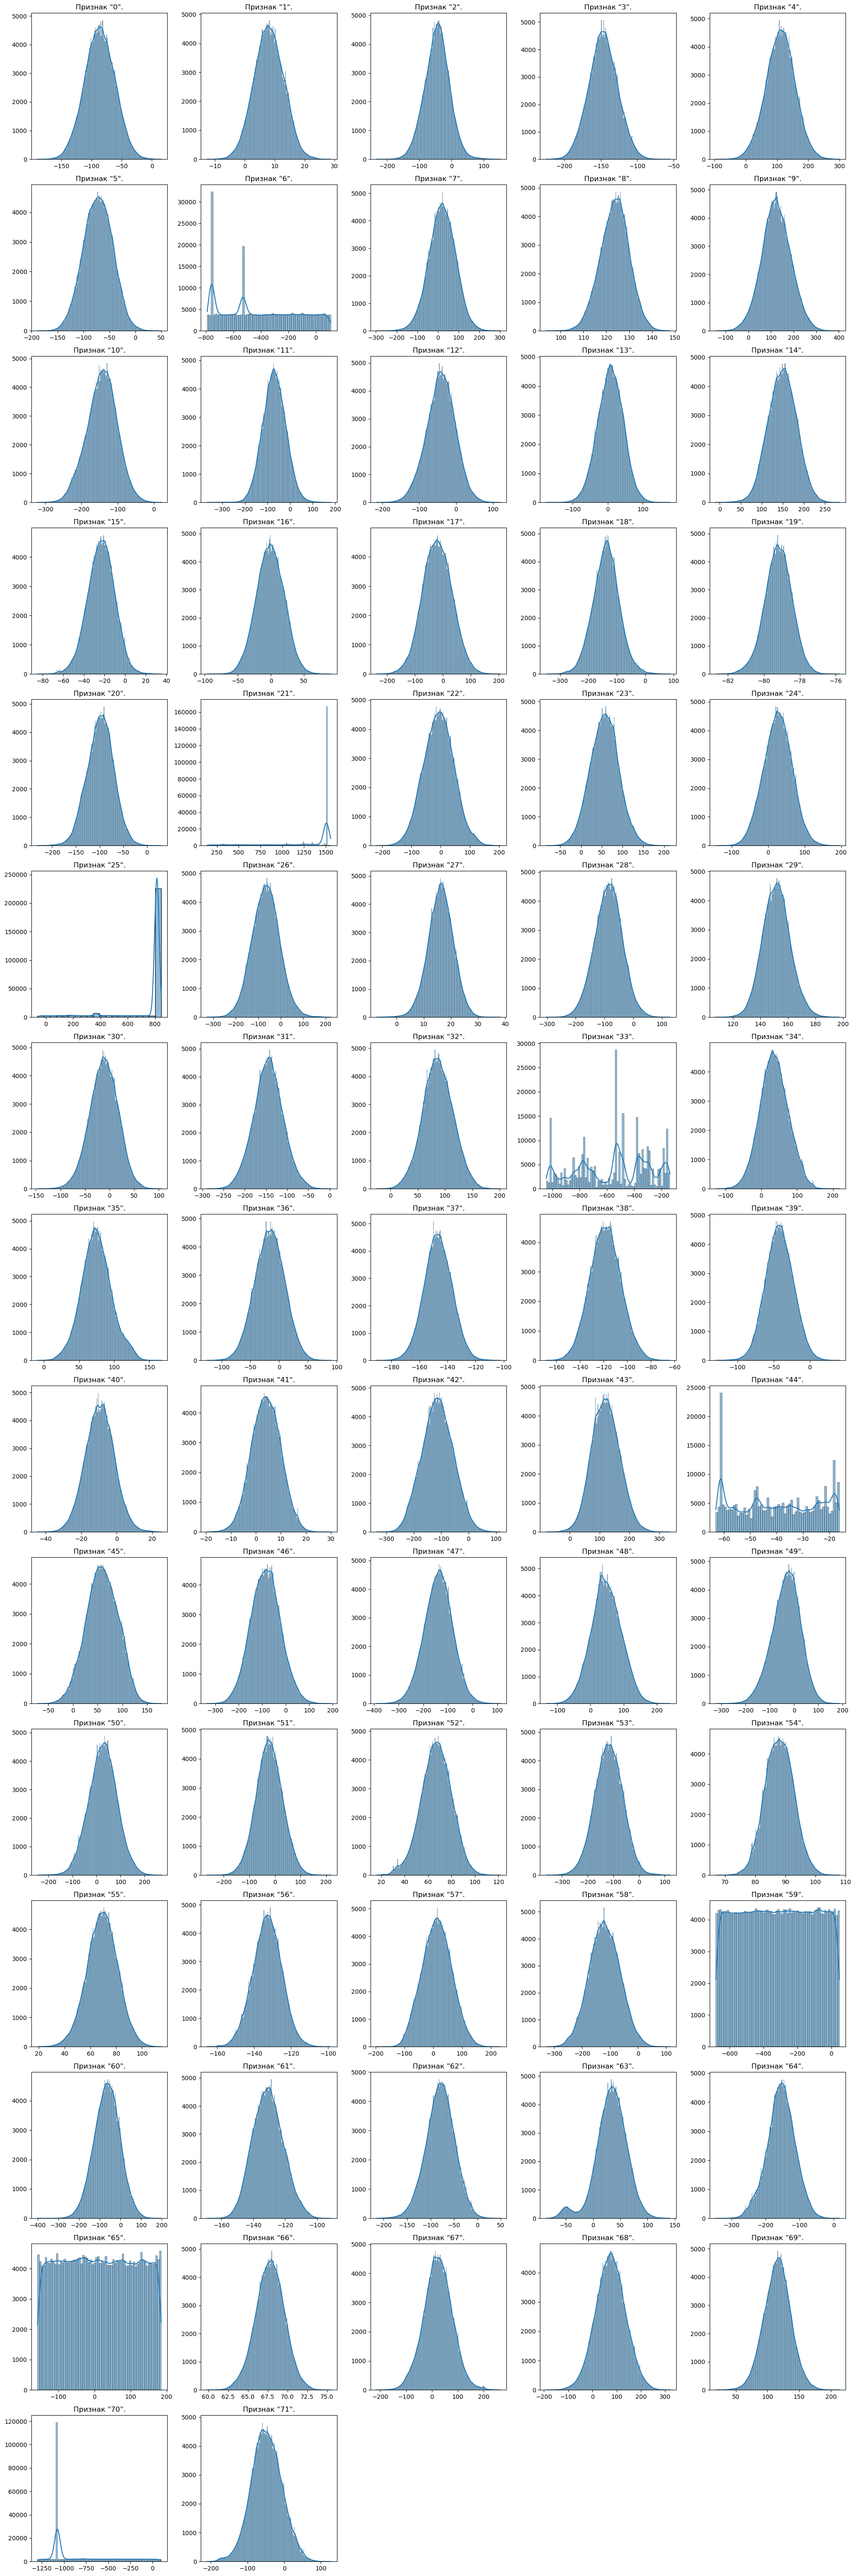

In [45]:
plot_distributions2(df_base)

Сделаю скриншоты распределений (оч долго прорисовываются локально)

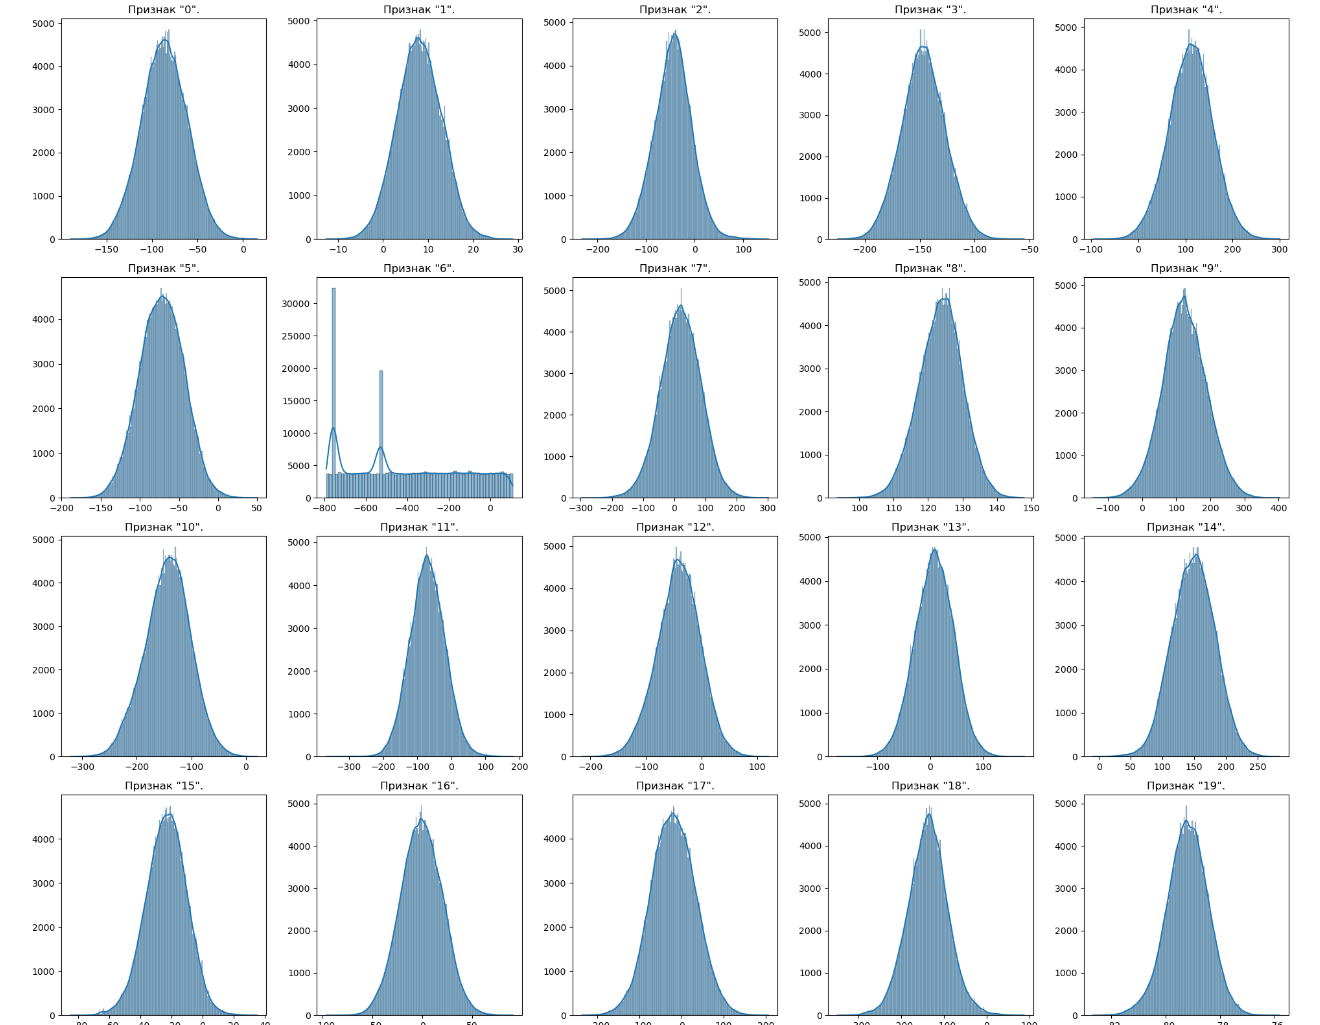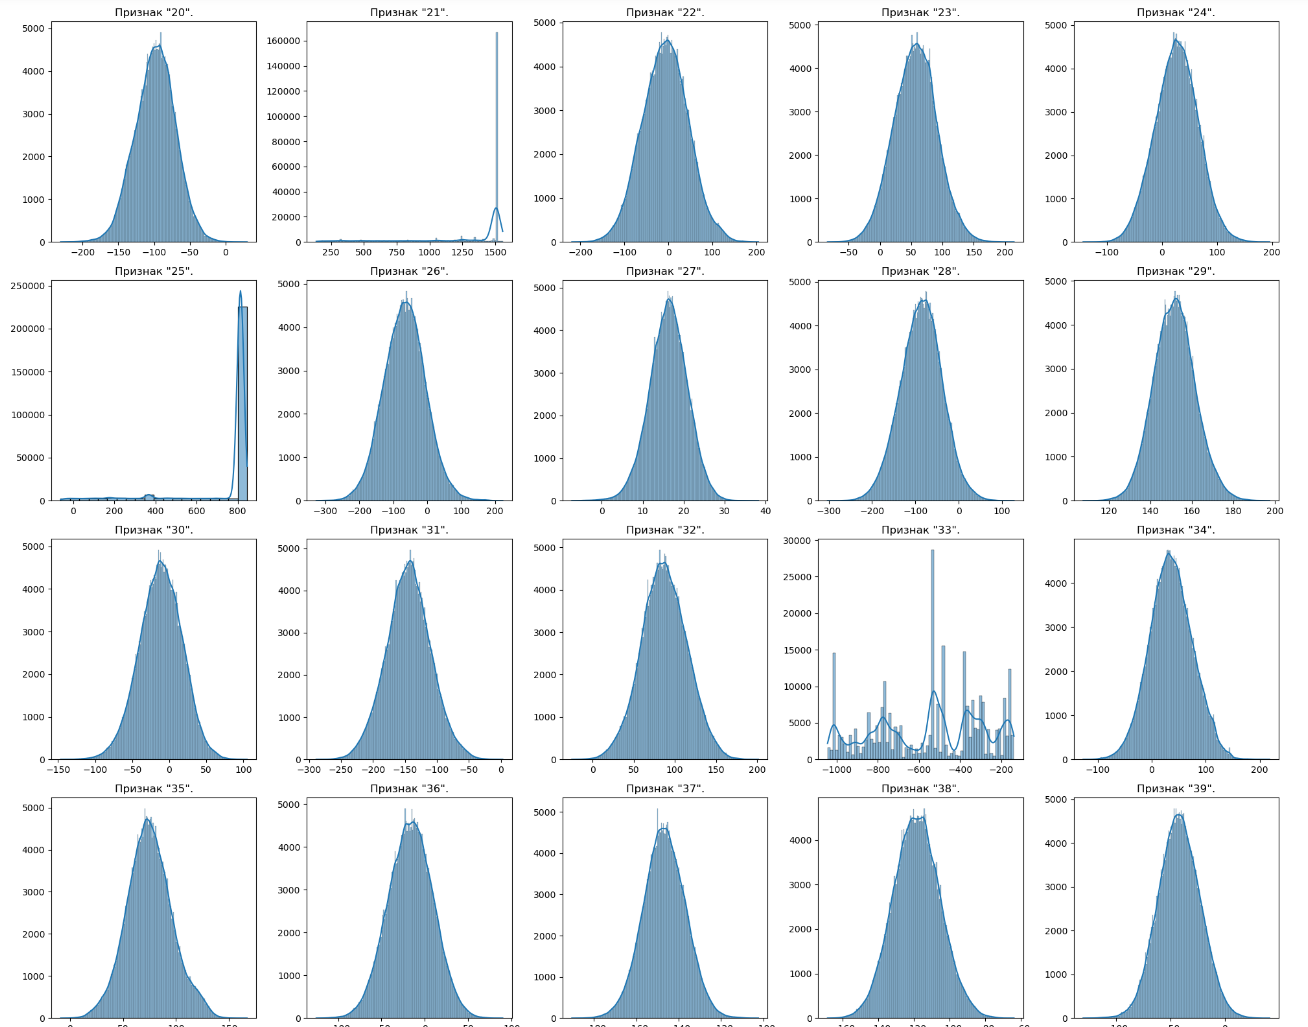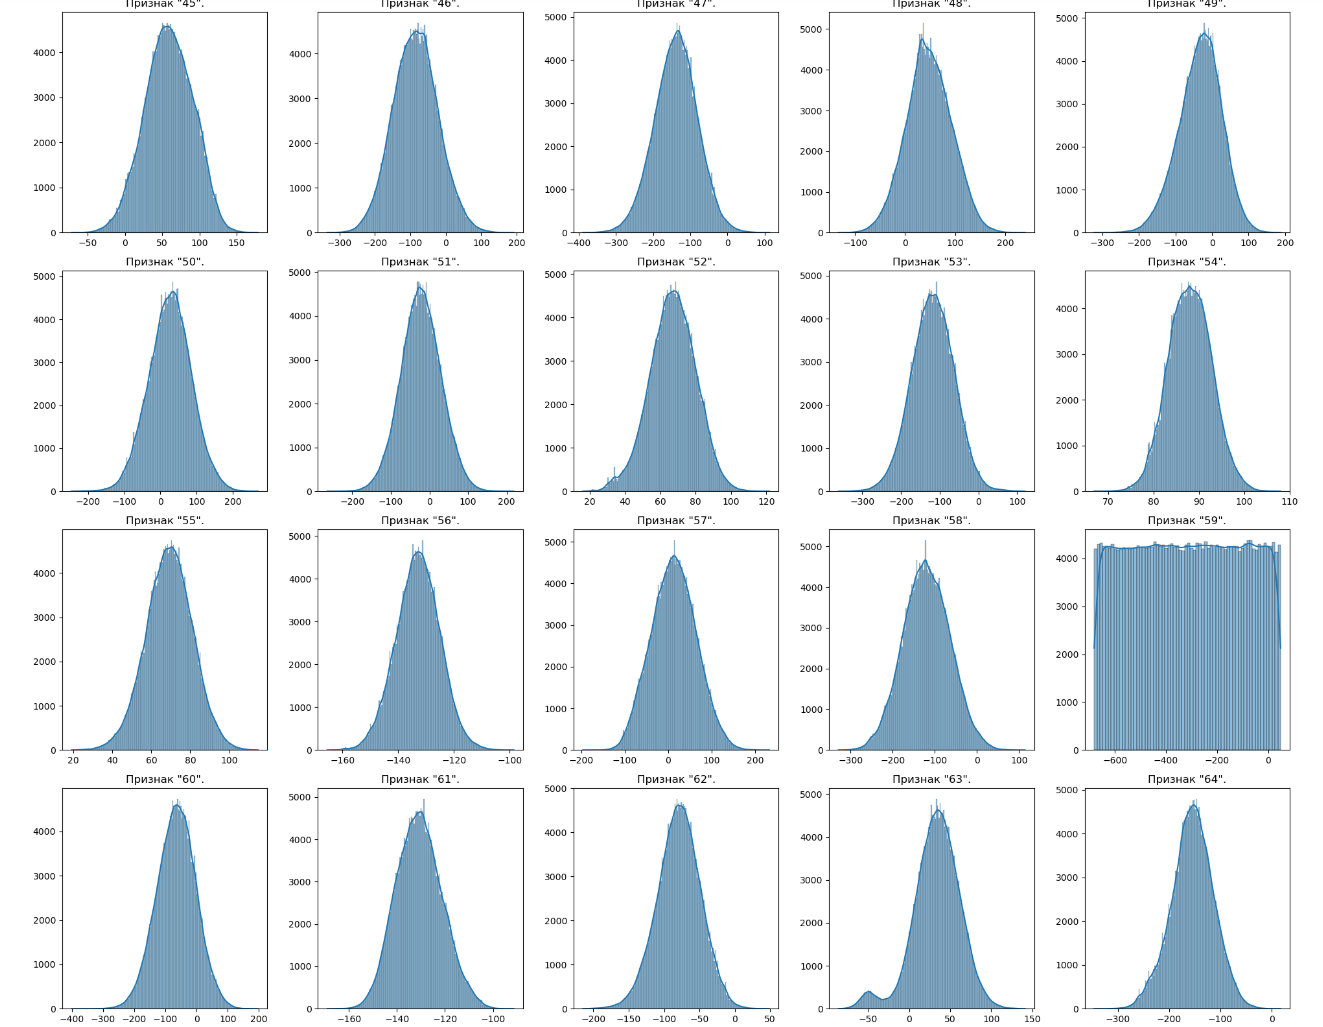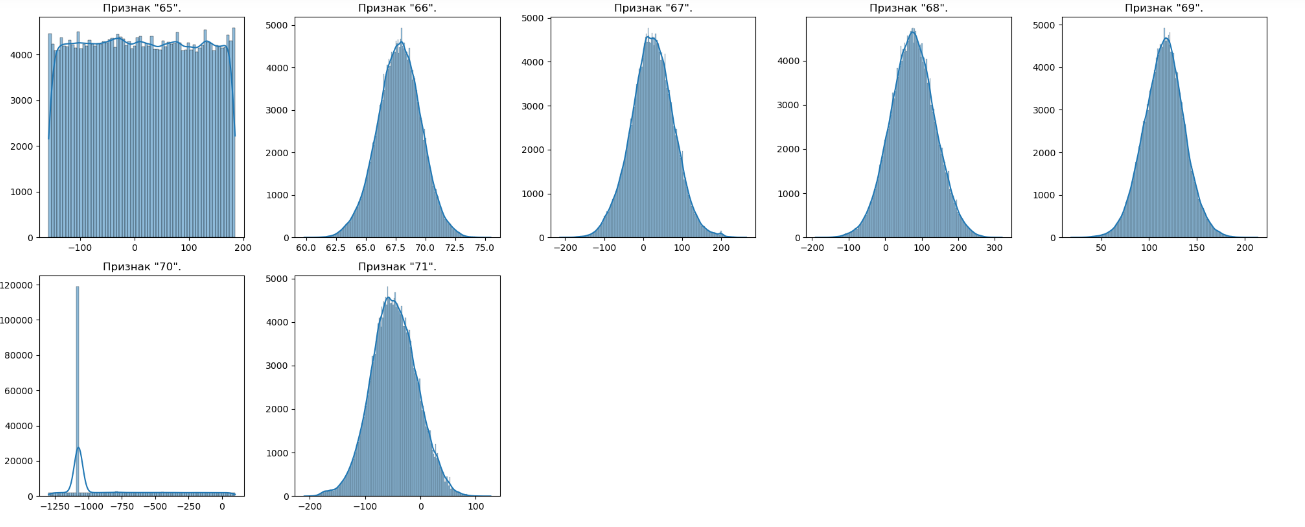

Наблюдаем, что распределения ряда признаков далеки от нормального. 
Признак 6 (значения распределены равномерно, с 2 явными пиками).
Признак 21 (ассиметричное распределение данные сконцентрированы на правом конце распределения)
Признак 25 (ассиметричное распределение данные сконцентрированы на правом конце распределения)
Признак 65 (значения распределены равномерно)
Признак 70 ((значения распределены равномерно, с 1 явным пиком).

Сделаем допущение что эти признаки не информативны и удалим из выборки.

In [46]:
df_base.columns

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24',
       '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36',
       '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48',
       '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60',
       '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71'],
      dtype='object')

In [47]:
columns_to_drop=['6', '21', '25', '65', '70']

In [48]:
df_base_small=df_base.drop(columns_to_drop, axis=1)

In [49]:
df_base_small.info()

<class 'pandas.core.frame.DataFrame'>
Index: 280535 entries, 4207931-base to 274130-base
Data columns (total 67 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       280535 non-null  float32
 1   1       280535 non-null  float32
 2   2       280535 non-null  float32
 3   3       280535 non-null  float32
 4   4       280535 non-null  float32
 5   5       280535 non-null  float32
 6   7       280535 non-null  float32
 7   8       280535 non-null  float32
 8   9       280535 non-null  float32
 9   10      280535 non-null  float32
 10  11      280535 non-null  float32
 11  12      280535 non-null  float32
 12  13      280535 non-null  float32
 13  14      280535 non-null  float32
 14  15      280535 non-null  float32
 15  16      280535 non-null  float32
 16  17      280535 non-null  float32
 17  18      280535 non-null  float32
 18  19      280535 non-null  float32
 19  20      280535 non-null  float32
 20  22      280535 non-null  float32
 21 

In [75]:
df_train_small=df_train.drop(columns_to_drop, axis=1)

In [78]:
df_base_small.shape

(280535, 67)

In [117]:
df_validation_small=df_validation.drop(columns_to_drop, axis=1)

In [118]:
df_validation_small.shape

(9735, 67)

In [51]:
#Масштабирование
X = StandardScaler().fit_transform(df_base_small)

In [79]:
df_train_small.shape

(9756, 68)

Итого по разделу:
- Проведен анализ распределений каждого из признаков
- Удалены неинформативные признаки из общего датасета, обучающей и валидационной выборки.

##  Расчет оптимального числа кластеров

In [68]:
# Диапазон количества кластеров для анализа
cluster_range = range(5, 501, 50)

# Список для хранения значений метрик
inertia = []

In [65]:
# Диапазон количества кластеров для анализа с шагом 5
cluster_range = range(5, 501, 5)

In [66]:
def plot_elbow_method(df, cluster_range):
    # Масштабирование данных
    X = StandardScaler().fit_transform(df)
    
    # Список для хранения значений метрики локтя
    inertia = []

    # Выполнение кластеризации и вычисление метрики локтя
    for n_clusters in tqdm(cluster_range):
        kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=42, n_init=2, max_iter=100, batch_size=100)
        kmeans.fit(X)
        inertia.append(kmeans.inertia_)

    # Построение графика
    plt.figure(figsize=(10, 6))
    plt.plot(cluster_range, inertia, marker='o')
    plt.xlabel('Количество кластеров')
    plt.ylabel('Inertia')
    plt.title('Метод локтя для определения оптимального числа кластеров')
    plt.grid(True)
    plt.show()

  0%|          | 0/100 [00:00<?, ?it/s]

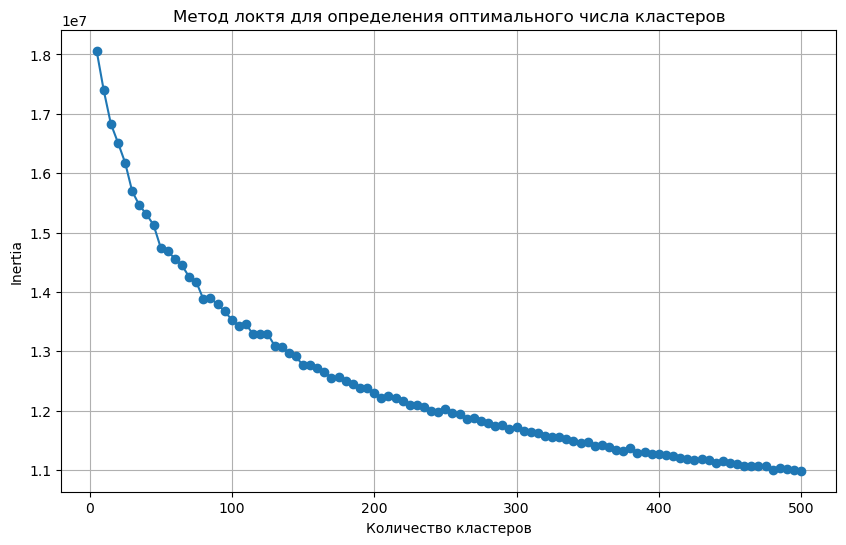

In [67]:
plot_elbow_method(df_base_small, cluster_range)

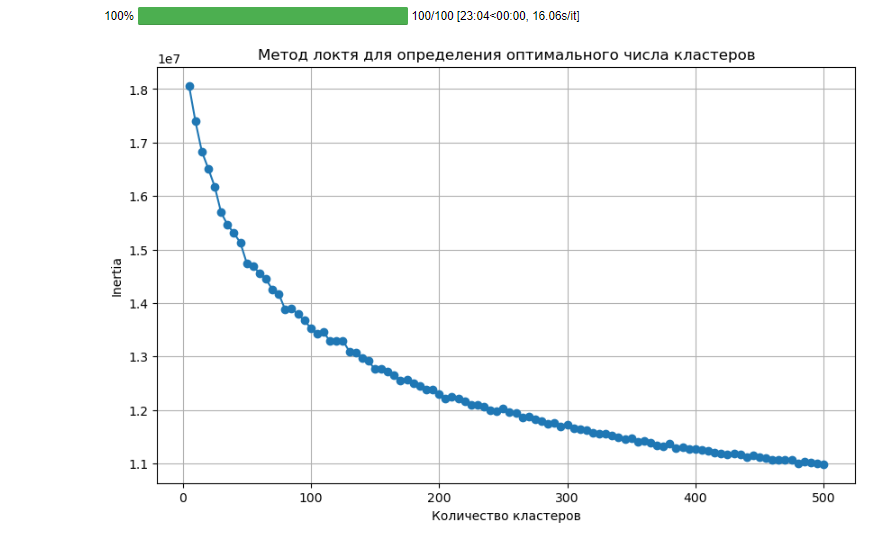

Наблюдаем что место изгиба (локтя) находится в районе 100 кластеров, дальшейшее увеличение числа кластеров вероятно приведет к усложнению решения (в т.ч. доп вычислений) без значительного прироста метрики инерции. Возьмем это значение за основу при работе с FAISS

Итого по разделу:
- Построили график соотношения метрики inertia c числом кластеров (метод локтя)
- Подобрали оптимальное число кластеров (100) для использования на следующих шагах проекта. 

## Кластеризация и применение  FAISS для поиска ближайших соседей

### Кластеризация данных на df_base_small используя оптимальное количество кластеров (100). Обучим к-means

In [80]:
# Масштабирование данных
X_base = StandardScaler().fit_transform(df_base_small)

In [81]:
# Обучение KMeans
optimal_clusters = 100
kmeans = MiniBatchKMeans(n_clusters=optimal_clusters, random_state=42, n_init=2, max_iter=100, batch_size=100)
kmeans.fit(X_base)

MiniBatchKMeans(batch_size=100, n_clusters=100, n_init=2, random_state=42)

In [94]:
# Присвоим метки кластеров
cluster_labels_base = kmeans.labels_

In [95]:
# Запишем центроиды кластеров
cluster_centers = kmeans.cluster_centers_

In [100]:
# Масштабирование данных
X_train = StandardScaler().fit_transform(df_train_small.drop(columns=['target']))

### Создание индекс FAISS и определение ближайших соседей для записей в тренировочных данных

In [96]:
# Запишем в переменную размерности векторов
d = cluster_centers.shape[1]

In [97]:
# Создадим индекс FAISS (по Евклидову расстоянию)
index = faiss.IndexFlatL2(d)

In [98]:
# Добавим центроиды в индекс
index.add(cluster_centers)

In [101]:
# Находим ближайшие центроиды для каждой записи в X_train
distances, indices = index.search(X_train, 1) 

In [102]:
# Переведем в одномерный массив и запишем  в nearest_cluster_labels индексы кластеров для каждой записи в df_train_small
nearest_cluster_labels = indices.flatten()

In [103]:
nearest_cluster_labels

array([19, 59,  1, ...,  8, 27, 67], dtype=int64)

In [104]:
# Создадим словарь, где ключами будут выступать номера кластеров, а значениями индексы записей df_base_small
cluster_to_indices = {i: np.where(cluster_labels_base == i)[0] for i in range(optimal_clusters)}

In [160]:
cluster_to_indices

{0: array([    43,     69,    117, ..., 280103, 280175, 280348], dtype=int64),
 1: array([    52,    142,    352, ..., 280118, 280179, 280457], dtype=int64),
 2: array([    37,     39,     73, ..., 279300, 279910, 280429], dtype=int64),
 3: array([    34,     50,     53, ..., 280511, 280513, 280528], dtype=int64),
 4: array([    47,    100,    116, ..., 280413, 280487, 280506], dtype=int64),
 5: array([     5,     45,     54, ..., 280424, 280503, 280521], dtype=int64),
 6: array([    12,     72,    220, ..., 280078, 280192, 280451], dtype=int64),
 7: array([   163,    218,    306, ..., 280030, 280080, 280383], dtype=int64),
 8: array([    42,     49,     81, ..., 280121, 280308, 280461], dtype=int64),
 9: array([    63,    298,    497, ..., 280471, 280488, 280526], dtype=int64),
 10: array([    56,     91,    135, ..., 280265, 280452, 280481], dtype=int64),
 11: array([   154,    312,    441, ..., 280087, 280136, 280177], dtype=int64),
 12: array([   264,    304,    403, ..., 280217, 2

In [106]:
# Для каждой записи в df_train_small, найти 5 ближайших соседей в кластере найденного ближайшего центроида
# Создадим пустой список 
nearest_neighbors = []
for i, cluster_label in enumerate(nearest_cluster_labels):
    # Соберем в переменную cluster_indices все индексы записей в кластерe, в cluster_data сами данные. 
    cluster_indices = cluster_to_indices[cluster_label]
    cluster_data = X_base[cluster_indices]
    
    # Создание временного индекса для текущего кластера
    temp_index = faiss.IndexFlatL2(d)
    temp_index.add(cluster_data)
    
    # Поиск ближайших соседей для текущей записи
    _, nn_indices = temp_index.search(np.expand_dims(X_train[i], axis=0), 5)
    
    # Запись индексов ближайших соседей
    nearest_neighbors.append(cluster_indices[nn_indices.flatten()])

### Посчитаем метрику на тренировочной выборке.

In [107]:
# Получение списка меток из target
true_labels = df_train_small['target'].values

In [110]:
# Оценка accuracy@5
correct_predictions = 0

for i, true_label in enumerate(true_labels):
    nearest_neighbor_indices = nearest_neighbors[i]
    nearest_neighbor_ids = df_base_small.index[nearest_neighbor_indices].tolist()
    # Проверка, есть ли в ближайших соседях целевой товар
    if true_label in nearest_neighbor_ids:
        correct_predictions += 1

# Рассчет метрики
accuracy_at_5 = correct_predictions / len(true_labels)
print(f"Accuracy@5: {accuracy_at_5:.2f}")

Accuracy@5: 0.64


### Определим ближайших соседей для валидационной выборки

In [144]:
# Объединение df_validation_small и df_validation_answer по индексу с использованием левого соединения
df_validation_combined = df_validation_small.merge(df_validation_answer, left_index=True, right_index=True, how='left')

In [145]:
check_df(df_validation_combined)

Общая инфо:
<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 100003-query to 99975-query
Data columns (total 68 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   0         10000 non-null  float32
 1   1         10000 non-null  float32
 2   2         10000 non-null  float32
 3   3         10000 non-null  float32
 4   4         10000 non-null  float32
 5   5         10000 non-null  float32
 6   7         10000 non-null  float32
 7   8         10000 non-null  float32
 8   9         10000 non-null  float32
 9   10        10000 non-null  float32
 10  11        10000 non-null  float32
 11  12        10000 non-null  float32
 12  13        10000 non-null  float32
 13  14        10000 non-null  float32
 14  15        10000 non-null  float32
 15  16        10000 non-null  float32
 16  17        10000 non-null  float32
 17  18        10000 non-null  float32
 18  19        10000 non-null  float32
 19  20        10000 non-null  float32
 20  22  

,0,1,2,3,4,5,7,8,9,10,11,12,13,14,15,16,17,18,19,20,22,23,24,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,66,67,68,69,71,Expected
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100003-query,-99.286858,16.123936,9.837166,-148.060440,83.697083,-133.729721,-19.046659,115.042404,75.206734,-114.271957,-71.406456,-65.349319,24.377069,50.467300,-14.721335,15.069309,-46.682995,-176.604370,-78.690697,-139.227448,3.632292,74.929504,-4.802103,-52.982597,15.644382,-54.087467,151.309143,21.088570,-134.507889,65.118958,-529.295044,131.565521,67.642700,-22.884491,-145.906525,-86.917328,-11.863579,-22.188885,0.463720,-212.533752,170.522583,-48.092533,99.712555,-194.692413,-141.523178,60.217049,73.386383,118.567856,58.900810,55.569031,-181.091660,83.340485,66.083237,-114.048866,-57.156872,-56.335075,-318.680054,-15.984783,-128.101334,-77.236107,44.100494,-132.530121,70.883957,23.577892,133.183960,143.252945,-89.392670,3168654-base
100051-query,-158.063309,10.684696,-98.307343,-138.418243,122.762650,-85.019730,-68.078514,119.363998,186.825806,-165.344757,-71.615219,19.999905,-31.159166,127.065765,-34.475822,2.311898,-30.289507,-159.762787,-79.957832,-91.869064,69.376549,99.475159,76.129822,-39.250290,8.188107,-94.363640,159.079666,-42.987431,-142.954758,55.490822,-432.576202,-46.853352,80.127960,-14.781672,-138.847443,-144.915253,-48.507973,-27.293200,-5.951070,-117.086449,120.986687,-32.429035,58.696674,-154.862671,-67.505959,69.446800,-105.327507,-69.292984,0.744764,77.703598,-88.047806,89.343880,92.747040,-127.268936,17.580509,-188.359711,-175.514313,-11.780083,-142.230026,-101.281082,57.061592,-171.926407,66.859848,-50.180515,139.071014,79.977524,-49.648342,321777-base
10006-query,-51.255787,11.645663,0.798058,-148.513245,139.422760,-103.686356,-36.050781,117.017273,96.598068,-124.276840,60.876457,8.851795,29.333685,140.303314,-18.706406,22.088423,-54.807812,-16.209045,-79.922691,-83.802322,-39.488377,25.751457,-9.738741,-25.294621,12.225915,-76.303841,143.638489,-4.500413,-134.125259,107.516945,-1006.426819,74.712326,101.866875,-1.513749,-141.009796,-103.350533,-24.789986,-11.194690,4.414606,-60.464596,93.969376,-45.198059,3.230328,-44.782272,-131.122498,23.303434,-21.701317,102.940414,-47.075207,60.615044,-175.175156,81.641418,53.075935,-150.017395,48.456608,-155.965958,-474.434326,-105.812943,-150.410080,-59.266777,36.081131,-174.172974,68.904793,-26.825989,189.177826,101.379280,-117.307007,180015-base
100063-query,-129.477234,9.426457,-91.378586,-175.656921,150.572754,-26.644268,0.186871,120.372856,168.197784,-205.484665,-56.578239,-37.649811,102.090096,137.997559,-22.404478,16.448484,-74.609726,-129.636627,-79.615196,-78.395309,-53.676323,96.679977,83.134567,-62.473671,12.538666,-116.791702,155.336365,-45.635994,-157.602814,65.137489,-481.586945,39.094296,28.720695,-19.040092,-145.359879,-99.269478,-45.845886,-32.296463,8.281429,-220.252930,56.396828,-34.920177,66.267220,-145.746872,-141.542511,10.857040,-92.838959,47.601112,-32.429577,63.930805,-177.410614,91.182297,95.472839,-126.869308,15.349028,-263.155212,-201.101227,16.860497,-132.341919,-95.150803,89.894318,-135.955032,67.759499,41.211712,35.896229,106.230515,-57.438828,2070630-base
100081-query,-93.771622,14.890013,-59.126717,-140.735092,116.238777,-84.644562,-126.844002,119.652634,208.313416,-203.737381,-49.758522,-42.474380,8.051764,191.409454,-37.965031,-9.313023,-3.074289,-150.169998,-80.003082,-85.558090,-28.123970,30.592281,56.192394,-94.158890,9.482279,-126.323235,147.634842,-55.689354,-154.505661,75.307526,-481.586945,63.254028,44.810188,-51.344566,-166.777344,-126.250641,-61.944111,-29.049110,-8.341609,-148.363220,140.809525,-19.489283,57.720306,-132.162262,-107.421150,95.219528,-86.235947,0.745003,-24.806856,88.062958,-126.639259,89.276382,91.732628,-135.346176,69.185707,-190.664856,-236.240036,-52.231812,-121.111580,-115.505760,61.044312,-152.379761,69.025497,-12.668772,14

In [147]:
df_validation_combined=df_validation_combined.drop_duplicates()

In [148]:
check_df(df_validation_combined)

Общая инфо:
<class 'pandas.core.frame.DataFrame'>
Index: 9735 entries, 100003-query to 99975-query
Data columns (total 68 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   0         9735 non-null   float32
 1   1         9735 non-null   float32
 2   2         9735 non-null   float32
 3   3         9735 non-null   float32
 4   4         9735 non-null   float32
 5   5         9735 non-null   float32
 6   7         9735 non-null   float32
 7   8         9735 non-null   float32
 8   9         9735 non-null   float32
 9   10        9735 non-null   float32
 10  11        9735 non-null   float32
 11  12        9735 non-null   float32
 12  13        9735 non-null   float32
 13  14        9735 non-null   float32
 14  15        9735 non-null   float32
 15  16        9735 non-null   float32
 16  17        9735 non-null   float32
 17  18        9735 non-null   float32
 18  19        9735 non-null   float32
 19  20        9735 non-null   float32
 20  22   

,0,1,2,3,4,5,7,8,9,10,11,12,13,14,15,16,17,18,19,20,22,23,24,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,66,67,68,69,71,Expected
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100003-query,-99.286858,16.123936,9.837166,-148.060440,83.697083,-133.729721,-19.046659,115.042404,75.206734,-114.271957,-71.406456,-65.349319,24.377069,50.467300,-14.721335,15.069309,-46.682995,-176.604370,-78.690697,-139.227448,3.632292,74.929504,-4.802103,-52.982597,15.644382,-54.087467,151.309143,21.088570,-134.507889,65.118958,-529.295044,131.565521,67.642700,-22.884491,-145.906525,-86.917328,-11.863579,-22.188885,0.463720,-212.533752,170.522583,-48.092533,99.712555,-194.692413,-141.523178,60.217049,73.386383,118.567856,58.900810,55.569031,-181.091660,83.340485,66.083237,-114.048866,-57.156872,-56.335075,-318.680054,-15.984783,-128.101334,-77.236107,44.100494,-132.530121,70.883957,23.577892,133.183960,143.252945,-89.392670,3168654-base
100051-query,-158.063309,10.684696,-98.307343,-138.418243,122.762650,-85.019730,-68.078514,119.363998,186.825806,-165.344757,-71.615219,19.999905,-31.159166,127.065765,-34.475822,2.311898,-30.289507,-159.762787,-79.957832,-91.869064,69.376549,99.475159,76.129822,-39.250290,8.188107,-94.363640,159.079666,-42.987431,-142.954758,55.490822,-432.576202,-46.853352,80.127960,-14.781672,-138.847443,-144.915253,-48.507973,-27.293200,-5.951070,-117.086449,120.986687,-32.429035,58.696674,-154.862671,-67.505959,69.446800,-105.327507,-69.292984,0.744764,77.703598,-88.047806,89.343880,92.747040,-127.268936,17.580509,-188.359711,-175.514313,-11.780083,-142.230026,-101.281082,57.061592,-171.926407,66.859848,-50.180515,139.071014,79.977524,-49.648342,321777-base
10006-query,-51.255787,11.645663,0.798058,-148.513245,139.422760,-103.686356,-36.050781,117.017273,96.598068,-124.276840,60.876457,8.851795,29.333685,140.303314,-18.706406,22.088423,-54.807812,-16.209045,-79.922691,-83.802322,-39.488377,25.751457,-9.738741,-25.294621,12.225915,-76.303841,143.638489,-4.500413,-134.125259,107.516945,-1006.426819,74.712326,101.866875,-1.513749,-141.009796,-103.350533,-24.789986,-11.194690,4.414606,-60.464596,93.969376,-45.198059,3.230328,-44.782272,-131.122498,23.303434,-21.701317,102.940414,-47.075207,60.615044,-175.175156,81.641418,53.075935,-150.017395,48.456608,-155.965958,-474.434326,-105.812943,-150.410080,-59.266777,36.081131,-174.172974,68.904793,-26.825989,189.177826,101.379280,-117.307007,180015-base
100063-query,-129.477234,9.426457,-91.378586,-175.656921,150.572754,-26.644268,0.186871,120.372856,168.197784,-205.484665,-56.578239,-37.649811,102.090096,137.997559,-22.404478,16.448484,-74.609726,-129.636627,-79.615196,-78.395309,-53.676323,96.679977,83.134567,-62.473671,12.538666,-116.791702,155.336365,-45.635994,-157.602814,65.137489,-481.586945,39.094296,28.720695,-19.040092,-145.359879,-99.269478,-45.845886,-32.296463,8.281429,-220.252930,56.396828,-34.920177,66.267220,-145.746872,-141.542511,10.857040,-92.838959,47.601112,-32.429577,63.930805,-177.410614,91.182297,95.472839,-126.869308,15.349028,-263.155212,-201.101227,16.860497,-132.341919,-95.150803,89.894318,-135.955032,67.759499,41.211712,35.896229,106.230515,-57.438828,2070630-base
100081-query,-93.771622,14.890013,-59.126717,-140.735092,116.238777,-84.644562,-126.844002,119.652634,208.313416,-203.737381,-49.758522,-42.474380,8.051764,191.409454,-37.965031,-9.313023,-3.074289,-150.169998,-80.003082,-85.558090,-28.123970,30.592281,56.192394,-94.158890,9.482279,-126.323235,147.634842,-55.689354,-154.505661,75.307526,-481.586945,63.254028,44.810188,-51.344566,-166.777344,-126.250641,-61.944111,-29.049110,-8.341609,-148.363220,140.809525,-19.489283,57.720306,-132.162262,-107.421150,95.219528,-86.235947,0.745003,-24.806856,88.062958,-126.639259,89.276382,91.732628,-135.346176,69.185707,-190.664856,-236.240036,-52.231812,-121.111580,-115.505760,61.044312,-152.379761,69.025497,-12.668772,14

In [151]:
# Масштабирование данных df_validation_small
X_validation = StandardScaler().fit_transform(df_validation_combined.drop(columns=['Expected']))

In [152]:
X_validation.shape

(9735, 67)

In [153]:
# Находим ближайшие центроиды для каждой записи для валидационной выборки
distances_val, indices_val = index.search(X_validation, 1)

In [154]:
# Запишем в nearest_cluster_labels_val метки кластеров для каждой записи в валидационной выборке
nearest_cluster_labels_val = indices_val.flatten()

In [155]:
# Для каждой записи валидационной выборки, найдем 5 ближайших соседей в кластере найденного ближайшего центроида
nearest_neighbors_val = []

In [156]:
for i, cluster_label in enumerate(nearest_cluster_labels_val):
    # Получение всех записей в кластере
    cluster_indices = cluster_to_indices[cluster_label]
    
    if len(cluster_indices) < 5:
        print(f"Cluster {cluster_label} has less than 5 members, skipping...")
        nearest_neighbors_val.append(cluster_indices)
        continue
    
    cluster_data = X_base[cluster_indices]
    
    # Создание временного индекса для текущего кластера
    temp_index = faiss.IndexFlatL2(d)
    temp_index.add(cluster_data)
    
    # Поиск ближайших соседей для текущей записи
    _, nn_indices = temp_index.search(np.expand_dims(X_validation[i], axis=0), 5)
    
    # Запись индексов ближайших соседей
    nearest_neighbors_val.append(cluster_indices[nn_indices.flatten()])

### Посчитаем метрику на валидационной выборке.

In [157]:
# Получение списка меток из df_validation_answer
true_labels_val = df_validation_combined['Expected'].values

In [158]:
# Оценка accuracy@5 для валидационной выборки
correct_predictions_val = 0

for i, true_label in enumerate(true_labels_val):
    nearest_neighbor_indices = nearest_neighbors_val[i]
    
    if len(nearest_neighbor_indices) < 5:
        print(f"Not enough neighbors for sample {i}, skipping...")
        continue
    
    nearest_neighbor_ids = df_base_small.index[nearest_neighbor_indices].tolist()
    
    # Проверка, есть ли в ближайших соседях целевой товар
    if true_label in nearest_neighbor_ids:
        correct_predictions_val += 1

In [159]:
# Рассчет метрики
accuracy_at_5_val = correct_predictions_val / len(true_labels_val)
print(f"Validation Accuracy@5: {accuracy_at_5_val:.2f}")

Validation Accuracy@5: 0.63


Итого по разделу:
 - Кластеризовали базовый датасет с использованием k-mean
 - Применили FAISS для определения ближайших соседей для тренировочных и тестовых записей.
 - Посчитали метрику Accuracy@5 на тренировочных данных: 0.64
 - Посчитали метрику Accuracy@5 на валидационных данных: 0.63

## Итого по проекту

1. Настроено окружение и созданы необходимые для работы функции.
2. Загружены и изучены данные. Удалены явные дубликаты, форматы данных в таблицах приведены в соответствие
3. Проведен исследовательский анализ данных. Определены неинформативные признаки.
4. Расчитано оптимальное количество кластеров. Построили график соотношения метрики inertia c числом кластеров (метод локтя)
Подобрали оптимальное число кластеров (100) 
5. Применили библиотеку FAISS:
 - Кластеризовали базовый датасет с использованием k-mean
 - Применили FAISS для определения ближайших соседей для тренировочных и тестовых записей.
 - Посчитали метрику Accuracy@5 на тренировочных данных: 0.64
 - Посчитали метрику Accuracy@5 на валидационных данных: 0.63

## Предложения к улучшению проекта

1. Использовать полный датасет, проведя расчеты на сервере Google /Kaggle. В локальном окружении обработку этого объема данных  не потянул.
2. Применить другие метрики для определения оптимального числа кластеров (например силуэт).
3. Не успел поработать с гипперпараметрами FAISS. Ожидаю что подбор правильных индексов
param_distributions = {
    'index_type': ['Flat', 'IVF', 'PQ', 'HNSW'],
    'nlist': [10, 100, 200]}
может значительно поднять финальную метрику.
